In [ ]:
import re
import string
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-bda3cbc42658>", line 4, in <cell line: 4>
    import spacy
  File "/usr/local/lib/python3.10/dist-packages/spacy/__init__.py", line 6, in <module>
    from .errors import setup_default_warnings
  File "/usr/local/lib/python3.10/dist-packages/spacy/errors.py", line 3, in <module>
    from .compat import Literal
  File "/usr/local/lib/python3.10/dist-packages/spacy/compat.py", line 4, in <module>
    from thinc.util import copy_array
  File "/usr/local/lib/python3.10/dist-packages/thinc/__init__.py", line 5, in <module>
    from .config import registry
  File "/usr/local/lib/python3.10/dist-packages/thinc/config.py", line 5, in <module>
    from .types import Decorator
  File "/usr/local/lib/python3.10/dist-packages/thinc/types.py", line 25, in <module>
    from .compat i

TypeError: object of type 'NoneType' has no len()

In [ ]:
!pip install plotly

In [ ]:
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 58.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
!pip install dcor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.7 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 24.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


### Analysis.ipynb

#### NLP Analysis

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.cluster import KMeans

In [ ]:
# Download NLTK data files (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')

# Load Spacy model for French
nlp = spacy.load('fr_core_news_sm')

# Define French stopwords
french_stopwords = set(stopwords.words('french'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    text=re.sub(r'\s+', ' ', text).strip()
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in french_stopwords]
    # Lemmatize
    doc = nlp(' '.join(words))
    lemmatized_words = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_words)

In [ ]:
def preprocess_by_module(df0,df1):
    parcours = [
    "Comptabilité",
    "Management",
    "Mathématiques Appliquées à l’Analyse des Données et à l’Aide à la Décision",
    "Business Intelligence",
    "Business Information Systems"
]
    df0.insert(0, "Parcours", parcours[:len(df0)])
    # Sélectionner la colonne 'Parcours' et toutes les colonnes commençant par 'Semestre'
    modules_licence = df0[['Parcours'] + [col for col in df0.columns if 'Semestre' in col]]
    # Fusionner les colonnes 'Semestre 1', 'Semestre 2', ... en une seule colonne 'Modules'
    modules_licence['Modules'] = modules_licence.iloc[:, 1:].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)

    # Supprimer les anciennes colonnes 'Semestre 1', 'Semestre 2', ...
    modules_licence = modules_licence[['Parcours', 'Modules']]

    # Sélectionner la colonne 'Parcours' et toutes les colonnes commençant par 'Semestre'
    modules_master = df1[['Parcours'] + [col for col in df1.columns if 'Semestre' in col]]
    # Fusionner les colonnes 'Semestre 1', 'Semestre 2', ... en une seule colonne 'Modules'
    modules_master['Modules'] = modules_master.iloc[:, 1:].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)

    # Supprimer les anciennes colonnes 'Semestre 1', 'Semestre 2', ...
    modules_master = modules_master[['Parcours', 'Modules']]
    data_modules = pd.concat([modules_licence, modules_master], ignore_index=True)
    data_modules["Parcours"]= data_modules["Parcours"].replace({
        "Comptabilité": "LSGC",
        "Management": "LSGM",
        "Mathématiques Appliquées à l’Analyse des Données et à l’Aide à la Décision": "LMAD",
        "Business Intelligence": "BI",
        "Business Information Systems": "BIS",
        "marketing digital": "MKD",
        "Comptabilité, Contrôle, Audit": "CCA",
        "Management Digital et Systèmes d’Information": "MDSI",
        "Gestion Actuarielle et Modélisation Mathématique": "GAMMA",
        "Finance Digitale": "FIND",
        "Business Analytics": "BA"
    })
    # Remplacer les séparateurs ',' et '/' par une virgule ','
    data_modules['Modules'] = data_modules['Modules'].str.replace(r'[,/]', ',', regex=True)

    # Convertir la colonne 'Modules' en liste en séparant les éléments par la virgule
    data_modules['Modules'] = data_modules['Modules'].str.split(',')

    # Exploser la colonne 'Modules' pour créer une ligne par module
    data_modules = data_modules.explode('Modules')

    return data_modules

def preprocess_by_skills(df0,df1):
    parcours = [
    "Comptabilité",
    "Management",
    "Mathématiques Appliquées à l’Analyse des Données et à l’Aide à la Décision",
    "Business Intelligence",
    "Business Information Systems"
]
    df0.insert(0, "Parcours", parcours[:len(df0)])
    # Sélectionner la colonne 'Parcours' et toutes les colonnes commençant par 'Semestre'
    modules_licence = df0[['Parcours'] + [col for col in df0.columns if 'Compétences' in col]]
    # Fusionner les colonnes 'Semestre 1', 'Semestre 2', ... en une seule colonne 'Modules'
    modules_licence['Compétences'] = modules_licence.iloc[:, 1:].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)

    # Supprimer les anciennes colonnes 'Semestre 1', 'Semestre 2', ...
    modules_licence = modules_licence[['Parcours', 'Compétences']]

    # Sélectionner la colonne 'Parcours' et toutes les colonnes commençant par 'Semestre'
    modules_master = df1[['Parcours'] + [col for col in df1.columns if 'Compétences' in col]]
    # Fusionner les colonnes 'Semestre 1', 'Semestre 2', ... en une seule colonne 'Modules'
    modules_master['Compétences'] = modules_master.iloc[:, 1:].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)

    # Supprimer les anciennes colonnes 'Semestre 1', 'Semestre 2', ...
    modules_master = modules_master[['Parcours', 'Compétences']]
    data_modules = pd.concat([modules_licence, modules_master], ignore_index=True)
    data_modules["Parcours"]= data_modules["Parcours"].replace({
        "Comptabilité": "LSGC",
        "Management": "LSGM",
        "Mathématiques Appliquées à l’Analyse des Données et à l’Aide à la Décision": "LMAD",
        "Business Intelligence": "BI",
        "Business Information Systems": "BIS",
        "marketing digital": "MKD",
        "Comptabilité, Contrôle, Audit": "CCA",
        "Management Digital et Systèmes d’Information": "MDSI",
        "Gestion Actuarielle et Modélisation Mathématique": "GAMMA",
        "Finance Digitale": "FIND",
        "Business Analytics": "BA"
    })
    # Remplacer les séparateurs ',' et '/' par une virgule ','
    data_modules['Compétences'] = data_modules['Compétences'].str.replace(r'[,/]', ',', regex=True)

    # Convertir la colonne 'Modules' en liste en séparant les éléments par la virgule
    data_modules['Compétences'] = data_modules['Compétences'].str.split(',')

    # Exploser la colonne 'Modules' pour créer une ligne par module
    data_modules = data_modules.explode('Compétences')

    return data_modules

def visualize_modules(data_frames):
    data_modules = preprocess_by_module(data_frames[0], data_frames[1])
    # Réinitialiser les indices
    data_modules = data_modules.reset_index(drop=True)
    effectifs = data_modules['Modules'].value_counts()
    frequences = data_modules['Modules'].value_counts(normalize=True)
    pourcentages = frequences * 100

    #Summary
    # Tableau statistique
    tableau_statistique = pd.DataFrame({
        'Effectif': effectifs,
        'Fréquence Relative': frequences,
        'Pourcentage': pourcentages
    })

    # Réorganiser l'ordre des colonnes et ajouter un index propre
    tableau_statistique = tableau_statistique.reset_index().rename(columns={'index': 'Module'})
    print("Top 10 des modules les plus fréquents :", tableau_statistique.head(10))
    #Visualisation
    #Diagramme en Barres
    top_modules = tableau_statistique.head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Effectif', y='Modules', data=top_modules, palette="viridis")
    plt.title("Top 10 des Modules par Effectif")
    plt.xlabel("Effectif")
    plt.ylabel("Modules")
    plt.show()

    # Diagramme circulaire
    tableau_statistique.set_index('Modules')['Pourcentage'].head(10).plot.pie(
        autopct='%1.1f%%', figsize=(8, 8), cmap='coolwarm')
    plt.title("Répartition des 10 principaux modules (en %)")
    plt.ylabel("")
    plt.show()
def perform_statistical_analysis(data_frames):
    """Perform statistical analysis on program skills."""
    esprit_data = preprocess_by_module(data_frames[0], data_frames[1])
    reference_data = data_frames[2]

    # Create TF-IDF vectors
    vectorizer = TfidfVectorizer()
    esprit_vectors = vectorizer.fit_transform(esprit_data.iloc[:, 0])
    reference_vectors = vectorizer.transform(reference_data.iloc[:, 0])

    # Calculate similarity scores
    similarity_matrix = cosine_similarity(esprit_vectors, reference_vectors)

    # Perform statistical tests
    results = {
        'mean_similarity': np.mean(similarity_matrix),
        'std_similarity': np.std(similarity_matrix),
        'max_similarity': np.max(similarity_matrix),
        'min_similarity': np.min(similarity_matrix)
    }

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(
        similarity_matrix.flatten(),
        np.random.random(similarity_matrix.size)
    )
    results['t_test'] = {'t_statistic': t_stat, 'p_value': p_value}

    # Generate visualizations
    plt.figure(figsize=(10, 6))
    sns.heatmap(similarity_matrix, cmap='YlOrRd')
    plt.title('Skill Similarity Heatmap')
    plt.savefig('output/similarity_heatmap.png')

    return results

In [ ]:
def categorize_program_gaps(missing_skills, skill_categories):
    """Categorize missing skills into defined categories."""
    program_gaps = {}

    # Create reverse mapping of skills to categories
    skill_to_category = {}
    for category_id, skills in skill_categories.items():
        for skill in skills:
            skill_to_category[skill] = category_id

    # Group missing skills by category
    for skill in missing_skills:
        if skill in skill_to_category:
            category = f"Category {skill_to_category[skill]}"
            if category not in program_gaps:
                program_gaps[category] = []
            program_gaps[category].append(skill)

    return program_gaps

def calculate_priority_scores(program_gaps):
    """Calculate priority scores for each category."""
    priority_scores = {}

    # Get total number of gaps
    total_gaps = sum(len(skills) for skills in program_gaps.values())

    if total_gaps == 0:
        return priority_scores

    # Calculate weights based on category size
    weights = {
        'Technical': 0.4,
        'Soft Skills': 0.3,
        'Domain Knowledge': 0.2,
        'Tools': 0.1
    }

    # Calculate normalized scores
    for category, skills in program_gaps.items():
        # Base score from number of gaps
        base_score = len(skills) / total_gaps

        # Apply category weight
        weight = weights.get(category, 0.25)  # Default weight if category not found
        priority_scores[category] = base_score * weight * 100

    # Normalize scores to 0-1 range
    max_score = max(priority_scores.values()) if priority_scores else 1
    priority_scores = {
        k: round(v/max_score, 2)
        for k, v in priority_scores.items()
    }

    return dict(sorted(
        priority_scores.items(),
        key=lambda x: x[1],
        reverse=True
    ))
def get_priority_level(gap_size):
    """Determine priority level based on gap size."""
    if gap_size > 15:
        return 'Critical'
    elif gap_size > 10:
        return 'High'
    elif gap_size > 5:
        return 'Medium'
    else:
        return 'Low'

def generate_action_plan(priority_scores):
    """Generate specific actions based on priority scores."""
    actions = []

    for category, score in priority_scores.items():
        if score > 0.8:
            actions.append(f"Urgent: Develop new modules for {category}")
        elif score > 0.6:
            actions.append(f"High Priority: Update existing courses with {category} content")
        elif score > 0.4:
            actions.append(f"Medium Priority: Consider adding {category} workshops")
        else:
            actions.append(f"Low Priority: Monitor {category} skill requirements")

    # Add general recommendations
    actions.extend([
        "Partner with industry experts for practical training",
        "Implement continuous skill assessment",
        "Review curriculum annually against market trends"
    ])

    return actions


def generate_recommendations(skill_gaps, job_skills):
    """Generate detailed skill gap recommendations."""
    # Summarize skills into categories
    skill_categories = categorize_skills(job_skills)

    # Analyze gaps and create recommendations
    recommendations = analyze_gaps(skill_gaps, skill_categories)



    return recommendations

def categorize_skills(job_skills, n_categories=5):
    """Categorize skills using BERT and clustering."""
    from sentence_transformers import SentenceTransformer

    # Load multilingual BERT model
    model = SentenceTransformer('distilbert-multilingual-nli-stsb-quora-ranking')

    # Prepare skills for embedding
    all_skills = list(set([
        skill.strip()
        for skills in job_skills.values()
        for skill in skills
    ]))

    # Get embeddings and cluster
    embeddings = model.encode(all_skills)
    clusters = KMeans(n_clusters=n_categories).fit_predict(embeddings)

    # Group skills by cluster
    categories = {}
    for skill, cluster in zip(all_skills, clusters):
        if cluster not in categories:
            categories[cluster] = []
        categories[cluster].append(skill)

    return categories

def analyze_gaps(skill_gaps, skill_categories):
    """Analyze skill gaps and generate recommendations."""
    recommendations = {}

    for program, missing_skills in skill_gaps.items():
        if not missing_skills:
            continue

        # Categorize missing skills
        program_gaps = categorize_program_gaps(missing_skills, skill_categories)

        # Generate priority scores
        priority_scores = calculate_priority_scores(program_gaps)

        recommendations[program] = {
            'summary': {
                'total_gaps': len(missing_skills),
                'priority_level': get_priority_level(len(missing_skills)),
                'categories': program_gaps
            },
            'priorities': priority_scores,
            'actions': generate_action_plan(priority_scores)
        }

    return recommendations

In [ ]:
def visualize_priority_areas(recommendations):
    """Visualize priority areas across all programs using histogram."""
    # Extract priority scores by category
    priority_data = []
    labels = []

    for program, rec in recommendations.items():
        for category, score in rec['priorities'].items():
            priority_data.append({
                'Program': program,
                'Category': category,
                'Score': score * 100  # Convert to percentage
            })

    # Convert to DataFrame for plotting
    df = pd.DataFrame(priority_data)

    # Create histogram
    fig = px.histogram(
        df,
        x='Score',
        color='Category',
        facet_col='Program',
        nbins=20,
        title='Priority Areas Distribution by Program',
        labels={
            'Score': 'Priority Score (%)',
            'Number of Skills': 'Number of Skills'
        },
        category_orders={
            'Program': sorted(df['Program'].unique())
        }
    )

    # Update layout
    fig.update_layout(
        showlegend=True,
        legend_title_text='Skill Categories',
        barmode='overlay',
        bargap=0.1,
        height=600
    )

    # Add hover template
    fig.update_traces(
        hovertemplate="<br>".join([
            "Category: %{customdata[0]}",
            "Score: %{x:.1f}%",
            "Count: %{y}"
        ])
    )

    fig.show()

In [ ]:
def analyze_skills_gap(data_frames):
    """Analyze skills gap between programs and job market."""
    # 1. Process data frames
    program_data = preprocess_program_data(data_frames[0], data_frames[1])
    job_data = preprocess_job_data(data_frames[2])

    # 2. Extract skills
    program_skills = extract_program_skills(program_data)
    job_skills = extract_job_skills(job_data)

    # 3. Calculate similarities and gaps
    similarity_matrix = calculate_similarities(program_skills, job_skills)
    skill_gaps = find_skill_gaps(program_skills, job_skills)

    # 4. Visualize results
    visualize_results(similarity_matrix, skill_gaps, program_skills.keys(), job_skills.keys())
    recommendations=generate_recommendations(skill_gaps,job_skills)
    visualize_priority_areas(recommendations)
    return {
        'similarities': similarity_matrix,
        'gaps': skill_gaps,
        'recommendations': recommendations
    }

def preprocess_program_data(license_df, master_df):
    """Preprocess program data frames."""
    # Add program names if missing
    if 'Parcours' not in license_df.columns:
        license_df['Parcours'] = ['LSGC', 'LSGM', 'LMAD', 'BI', 'BIS']
    if 'Parcours' not in master_df.columns:
        # Get the number of rows in master_df
        num_rows = master_df.shape[0]
        # Repeat the program names to match the number of rows
        program_names = ['MKD', 'CCA', 'MDSI', 'GAMMA', 'FIND', 'BA']
        repeated_program_names = program_names * (num_rows // len(program_names)) + program_names[:num_rows % len(program_names)]
        master_df['Parcours'] = repeated_program_names

    # Combine and process competences
    program_data = pd.concat([
        license_df[['Parcours', 'Compétences']],
        master_df[['Parcours', 'Compétences']]
    ])

    return program_data.dropna()

def preprocess_job_data(job_df):
    """Preprocess job reference data."""
    return job_df[['job_name', 'compétences']].dropna()

def extract_program_skills(df):
    """Extract skills from program data."""
    skills_dict = {}
    for _, row in df.iterrows():
        program = row['Parcours']
        skills = set(str(row['Compétences']).lower().split(','))
        if program in skills_dict:
            skills_dict[program].update(skills)
        else:
            skills_dict[program] = skills
    return skills_dict

def extract_job_skills(df):
    """Extract skills from job data."""
    return {
        row['job_name']: set(str(row['compétences']).lower().split(','))
        for _, row in df.iterrows()
    }

def calculate_similarities(program_skills, job_skills):
    """Calculate similarity between programs and jobs."""
    vectorizer = TfidfVectorizer()
    prog_vectors = vectorizer.fit_transform([' '.join(s) for s in program_skills.values()])
    job_vectors = vectorizer.transform([' '.join(s) for s in job_skills.values()])
    return cosine_similarity(prog_vectors, job_vectors)

def find_skill_gaps(program_skills, job_skills):
    """Find missing skills in programs."""
    market_skills = set.union(*job_skills.values())
    return {
        program: list(market_skills - skills)
        for program, skills in program_skills.items()
    }

def visualize_results(similarity_matrix, gaps, program_names, job_names):
    """Create visualizations for analysis results."""
    # Similarity heatmap
    fig = px.imshow(
        similarity_matrix,
        x=list(job_names),
        y=list(program_names),
        title="Program-Job Skill Similarity"
    )
    fig.show()

    # Gap analysis
    gap_sizes = {p: len(g) for p, g in gaps.items()}
    fig = px.bar(
        x=list(gap_sizes.keys()),
        y=list(gap_sizes.values()),
        title="Missing Skills by Program"
    )
    fig.show()

In [ ]:
file_paths = ['licence.csv', 'masters.csv', 'scrapped_content_ref.csv']
output_path = 'output/combined_vectors2.csv'
# Run the pipeline
similarities = run_pipeline(file_paths, output_path,'PCA',2)

# Print the similarities
print("Similarities between files:")
for key, value in similarities.items():
    print(f"{key}:")
    for metric, metric_value in value.items():
        print(f"  {metric}: {metric_value}")


In [ ]:
# Load the processed data frames
data_frames = [process_file(file_path) for file_path in file_paths]

In [ ]:
from tabulate import tabulate
from termcolor import colored

def print_recommendations_table(recommendations):
    """Print recommendations in formatted tables."""
    for program, rec in recommendations.items():
        # Header
        print(f"\n{colored('Program Analysis: ' + program, 'blue', attrs=['bold'])}")

        # Summary Table
        summary_data = [
            ['Priority Level', colored(rec['summary']['priority_level'], get_priority_color(rec['summary']['priority_level']))],
            ['Total Skill Gaps', rec['summary']['total_gaps']]
        ]
        print("\nSummary:")
        print(tabulate(summary_data, tablefmt='grid'))

        # Priority Areas Table
        priority_data = [[area, f"{score:.2f}%"] for area, score in rec['priorities'].items()]
        print("\nPriority Areas:")
        print(tabulate(
            priority_data,
            headers=['Category', 'Priority Score'],
            tablefmt='grid'
        ))

        # Actions Table
        action_data = [[i, action] for i, action in enumerate(rec['actions'], 1)]
        print("\nRecommended Actions:")
        print(tabulate(
            action_data,
            headers=['#', 'Action Item'],
            tablefmt='grid'
        ))
        print("\n" + "="*80)

def get_priority_color(priority):
    """Get color based on priority level."""
    colors = {
        'Critical': 'red',
        'High': 'yellow',
        'Medium': 'cyan',
        'Low': 'green'
    }
    return colors.get(priority, 'white')


In [ ]:
# Usage in main.py
results = analyze_skills_gap(data_frames)
print_recommendations_table(results['recommendations'])


In [ ]:
# Visualize the top n-grams
visualize_ngrams(data_frames, n=2, top_n=20)

In [ ]:
# Visualize the top bigrams
visualize_bigrams(data_frames, top_n=20)


In [ ]:
# Compare n-grams between files
compare_ngrams_between_files(data_frames, n=2, top_n=20)


In [ ]:
# Visualize bigram similarity and frequency using t-SNE embeddings
visualize_bigram_similarity(data_frames, top_n=20,min_freq=2)

In [ ]:
# Visualize topic distributions using LDA
visualize_topic_distributions(data_frames, n_topics=5)

##### Interpretations

1.   #### Distance Covariance Interpretation
Distance covariance measures the statistical dependence between two variables, with values ranging from 0 (no dependence) to 1 (perfect dependence).<br />
may be lower because while the data might have similar patterns
(captured by RV), they may not have strong statistical dependence
(captured by distance covariance). For example, the two files might have similar content, but the way the content is distributed or structured could differ, leading to a lower distance covariance

2.   ####  RV Coefficient Interpretation
RV coefficient is a measure of similarity between two matrices. It can be interpreted as a value between 0 and 1 <br />
 high because the data in the files share very similar structures (even if those structures don't have a strong statistical dependency).

#### Statistical Analysis


##### Skills Descriptive Analysis

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import re
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_licence = pd.read_csv("/content/drive/MyDrive/Skill_Recommender/EDA/data/licence_Analysis.csv")
data_master = pd.read_csv("/content/drive/MyDrive/Skill_Recommender/EDA/data/masters_Analysis.csv")

In [ ]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
import re

stop_words = set(stopwords.words('french'))
stemmer = PorterStemmer()

def preprocess(df):
     # 1. Handle Missing Values:
    #df = df.fillna("")  # Replace NaN with empty strings to avoid errors

    # 2. Lowercase and Remove Punctuation/Numbers:
    df = df.apply(lambda x: re.sub(r'[^\w\s]', '', str(x).lower()) if isinstance(x, str) else x)  # Lowercase & remove punctuation
    df = df.apply(lambda x: re.sub(r'\d', '', str(x)) if isinstance(x, str) else x)  # Remove numbers

    # 3. Tokenization and Stop Word Removal:
    df = df.apply(lambda x: word_tokenize(str(x)) if isinstance(x, str) else x)  # Tokenize
    df = df.apply(lambda x: [word for word in x if word not in stop_words] if isinstance(x, list) else x)  # Remove stop words

    # 4. Stemming:
    df = df.apply(lambda x: [stemmer.stem(word) for word in x] if isinstance(x, list) else x)  # Stemming

    # 5. Join the list of stemmed words back into a string
    df = df.apply(lambda x: ' '.join(x) if isinstance(x, list) else x)  # Join back to string

    return df

In [ ]:
parcours = [
    "Comptabilité",
    "Management",
    "Mathématiques Appliquées à l’Analyse des Données et à l’Aide à la Décision",
    "Business Intelligence",
    "Business Information Systems"
]

data_licence.insert(0, "Parcours", parcours[:len(data_licence)])
competences_licence = data_licence[["Parcours", "Compétences"]]
competences_master = data_master[["Parcours", "Compétences"]]
data_competences = pd.concat([competences_licence, competences_master], ignore_index=True)


In [ ]:
# S'assurer que la colonne 'Compétences' contient bien des chaînes de caractères
data_competences['Compétences'] = data_competences['Compétences'].fillna('')  # Remplacer NaN par des chaînes vides
data_competences['Compétences'] = data_competences['Compétences'].astype(str)  # Convertir en chaînes de caractères

# Séparer les compétences par une virgule
data_competences['Compétences'] = data_competences['Compétences'].str.split(',')

# "Exploser" les lignes pour avoir une ligne par compétence
data_competences = data_competences.explode('Compétences')

# Nettoyer les espaces avant et après chaque compétence
data_competences['Compétences'] = data_competences['Compétences'].str.strip()

data_competences = data_competences.reset_index(drop=True)


In [ ]:
# Remplacer les caractères spéciaux pour toutes les colonnes (si elles contiennent du texte)
data_competences = data_competences.apply(lambda x: x.str.replace(r"[^\w\s]", " ", regex=True) if x.dtype == "object" else x)

# Supprimer les espaces multiples dans toutes les colonnes
data_competences = data_competences.apply(lambda x: x.str.replace(r"\s+", " ", regex=True).str.strip() if x.dtype == "object" else x)

In [ ]:
# Transformer en minuscules pour homogénéiser
data_competences["Parcours"] = data_competences["Parcours"].str.lower()
data_competences["Compétences"] = data_competences["Compétences"].str.lower()

In [ ]:
#Renommer les données
data_competences["Parcours"]= data_competences["Parcours"].replace({
    "comptabilité": "LSGC",
    "management": "LSGM",
    "mathématiques appliquées à l analyse des données et à l aide à la décision": "LMAD",
    "business intelligence": "BI",
    "business information systems": "BIS",
    "marketing digital": "MKD",
    "comptabilité contrôle audit": "CCA",
    "management digital et systèmes d information": "MDSI",
    "gestion actuarielle et modélisation mathématique": "GAMMA",
    "finance digitale": "FIND",
    "business analytics": "BA"
})
data_competences.head()

,Parcours,Compétences
0,LSGC,maîtriser les techniques d élaboration des sup...
1,LSGC,établir les déclarations fiscales et sociales ...
2,LSGC,préparer un rapport complet d analyse financiè...
3,LSGC,intervenir en tant que collaborateur dans les ...
4,LSGC,intervenir et évoluer dans un milieu juridique...


In [ ]:
data_competences = data_competences[data_competences['Compétences'] != 'la délivrance du diplôme est en outre soumise à l obtention du niveau b2 en français et en anglais']
data_competences = data_competences[~data_competences['Compétences'].str.replace(r'\s+', '', regex=True).eq('')]
data_competences = data_competences[~data_competences['Compétences'].str.startswith('la licence')]
data_competences = data_competences.reset_index(drop=True)

In [ ]:
print(data_competences.info())
print(f"\nRows: {data_competences.shape[0]}, Columns : {data_competences.shape[1]}")
print(f"\nnull values sum : {data_competences.isnull().sum()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Parcours     59 non-null     object
 1   Compétences  59 non-null     object
dtypes: object(2)
memory usage: 1.0+ KB
None

Rows: 59, Columns : 2

null values sum : Parcours       0
Compétences    0
dtype: int64


In [ ]:
# Tableau statistique
frequences = data_competences['Compétences'].value_counts(normalize=True)

tableau_statistique = pd.DataFrame({
    'Effectif': data_competences['Compétences'].value_counts(),
    'Fréquence Relative': frequences,
    'Pourcentage': frequences * 100
})

# Réorganiser l'ordre des colonnes et ajouter un index propre
tableau_statistique = tableau_statistique.reset_index().rename(columns={'index': 'Module'})
print("Tableau Statistique :")
tableau_statistique.head()

Tableau Statistique :


,Compétences,Effectif,Fréquence Relative,Pourcentage
0,maîtris techniqu délabor support commun compta...,1,0.027778,2.777778
1,analys évolut lenvironn affair analys donné pr...,1,0.027778,2.777778
2,anticiper et gérer les changements liés à la t...,1,0.027778,2.777778
3,sociale et sociétale des entreprises,1,0.027778,2.777778
4,adapter les outils de traitement statistique d...,1,0.027778,2.777778


##### Module Descriptive Analysis




In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import re
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_licence = pd.read_csv("/content/drive/MyDrive/Skill_Recommender/EDA/data/licence_Analysis.csv")
data_master = pd.read_csv("/content/drive/MyDrive/Skill_Recommender/EDA/data/masters_Analysis.csv")

In [ ]:
parcours = [
    "Comptabilité",
    "Management",
    "Mathématiques Appliquées à l’Analyse des Données et à l’Aide à la Décision",
    "Business Intelligence",
    "Business Information Systems"
]
data_licence.insert(0, "Parcours", parcours[:len(data_licence)])
# Sélectionner la colonne 'Parcours' et toutes les colonnes commençant par 'Semestre'
modules_licence = data_licence[['Parcours'] + [col for col in data_licence.columns if 'Semestre' in col]]
# Fusionner les colonnes 'Semestre 1', 'Semestre 2', ... en une seule colonne 'Modules'
modules_licence['Modules'] = modules_licence.iloc[:, 1:].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)

# Supprimer les anciennes colonnes 'Semestre 1', 'Semestre 2', ...
modules_licence = modules_licence[['Parcours', 'Modules']]

# Sélectionner la colonne 'Parcours' et toutes les colonnes commençant par 'Semestre'
modules_master = data_master[['Parcours'] + [col for col in data_master.columns if 'Semestre' in col]]
# Fusionner les colonnes 'Semestre 1', 'Semestre 2', ... en une seule colonne 'Modules'
modules_master['Modules'] = modules_master.iloc[:, 1:].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)

# Supprimer les anciennes colonnes 'Semestre 1', 'Semestre 2', ...
modules_master = modules_master[['Parcours', 'Modules']]
data_modules = pd.concat([modules_licence, modules_master], ignore_index=True)


<ipython-input-116-6d952288a514>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modules_licence['Modules'] = modules_licence.iloc[:, 1:].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)
<ipython-input-116-6d952288a514>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modules_master['Modules'] = modules_master.iloc[:, 1:].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)


In [ ]:
data_modules["Parcours"]= data_modules["Parcours"].replace({
    "Comptabilité": "LSGC",
    "Management": "LSGM",
    "Mathématiques Appliquées à l’Analyse des Données et à l’Aide à la Décision": "LMAD",
    "Business Intelligence": "BI",
    "Business Information Systems": "BIS",
    "marketing digital": "MKD",
    "Comptabilité, Contrôle, Audit": "CCA",
    "Management Digital et Systèmes d’Information": "MDSI",
    "Gestion Actuarielle et Modélisation Mathématique": "GAMMA",
    "Finance Digitale": "FIND",
    "Business Analytics": "BA"
})


In [ ]:
data_modules['Modules'] = data_modules['Modules'].str.replace(r'\s?I{1,3}\s?', '', regex=True)

# Supprimer les nombres dans la colonne 'Modules'
data_modules['Modules'] = data_modules['Modules'].apply(lambda x: re.sub(r'\d+', '', x))

# Nettoyer les espaces superflus et uniformiser les valeurs
data_modules['Modules'] = data_modules['Modules'].str.strip().str.lower()
# Remplacer les séparateurs ',' et '/' par une virgule ','
data_modules['Modules'] = data_modules['Modules'].str.replace(r'[,/]', ',', regex=True)

# Convertir la colonne 'Modules' en liste en séparant les éléments par la virgule
data_modules['Modules'] = data_modules['Modules'].str.split(',')
data_modules_clustering=data_modules.copy(deep=True)
# Exploser la colonne 'Modules' pour créer une ligne par module
data_modules = data_modules.explode('Modules')
data_modules['Modules'] = data_modules['Modules'].str.strip()
# Réinitialiser les indices
data_modules = data_modules.reset_index(drop=True)

In [ ]:
# Modalités
modalites = data_modules['Modules'].unique()
# Effectif par module
effectifs = data_modules['Modules'].value_counts()
# Fréquences relatives
frequences = data_modules['Modules'].value_counts(normalize=True)
# Pourcentages
pourcentages = frequences * 100


In [ ]:
# Tableau statistique
tableau_statistique = pd.DataFrame({
    'Effectif': effectifs,
    'Fréquence Relative': frequences,
    'Pourcentage': pourcentages
})

# Réorganiser l'ordre des colonnes et ajouter un index propre
tableau_statistique = tableau_statistique.reset_index().rename(columns={'index': 'Module'})
print("Tableau Statistique :")
tableau_statistique.head()

Tableau Statistique :


,Modules,Effectif,Fréquence Relative,Pourcentage
0,anglais,13,0.058296,5.829596
1,séminaire,7,0.031390,3.139013
2,projet intégré,5,0.022422,2.242152
3,projet tutoré,5,0.022422,2.242152
4,principes de gestion,4,0.017937,1.793722


<ipython-input-70-c2f5fb38ba97>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Effectif', y=top_compétences['Modules'].unique(), data=top_compétences, palette="viridis")


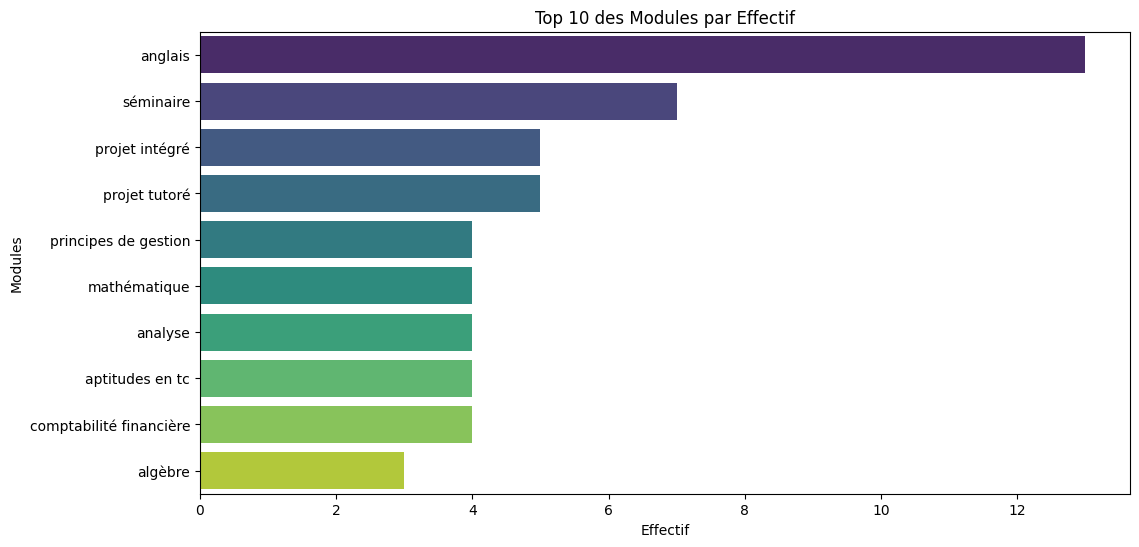

In [ ]:
# Top 10 des modules les plus fréquents
top_compétences = tableau_statistique.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='Effectif', y=top_compétences['Modules'].unique(), data=top_compétences, palette="viridis")
plt.title("Top 10 des Modules par Effectif")
plt.xlabel("Effectif")
plt.ylabel("Modules")
plt.show()

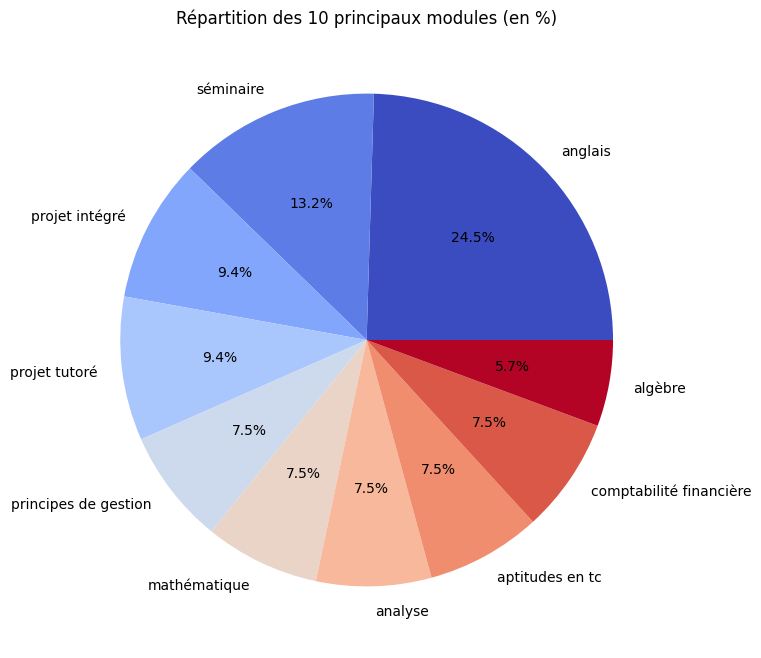

In [ ]:
# Diagramme circulaire
tableau_statistique.set_index('Modules')['Pourcentage'].head(10).plot.pie(
    autopct='%1.1f%%', figsize=(8, 8), cmap='coolwarm')
plt.title("Répartition des 10 principaux modules (en %)")
plt.ylabel("")
plt.show()

##### CrossTable


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
competences_esb = pd.read_csv("/content/drive/MyDrive/Skill_Recommender/EDA/data/competence_esb.csv")
competences_ref = pd.read_csv("/content/drive/MyDrive/Skill_Recommender/EDA/data/competence_ref.csv")

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
!pip install spacy
!python -m spacy download fr_core_news_sm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 20.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
spacy_nlp = spacy.load("fr_core_news_sm")  # Load spaCy's small model

In [ ]:
import re
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as FR_STOP_WORDS
import string
# Create list of punctuations and French stop words
punctuations = string.punctuation
stop_words = FR_STOP_WORDS
FRENCH_WORDS = list(stopwords.words('french'))

# Function for data cleaning and processing
def preprocess_text(sentence):
    sentence = sentence.lower()
    # Remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    # Remove digits and words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    # Replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    # Remove unwanted lines starting from special characters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)

    # Remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)

    # Remove punctuations
    sentence = re.sub(r'[^\w\s]',' ',sentence)

    #creating token object
    tokens = spacy_nlp(sentence)

    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]

    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    return ' '.join(tokens)

In [ ]:
competences_ref['Compétences'] = competences_ref['Compétences'].apply(preprocess_text)
competences_esb['Compétences'] =competences_esb['Compétences'].apply(preprocess_text)
competences_ref['métier'] =  competences_ref['métier'].apply(preprocess_text)

<ipython-input-17-0e036646c515>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(competences_ref['doc_len'], hist=True, kde=True, color='b', label='doc len')


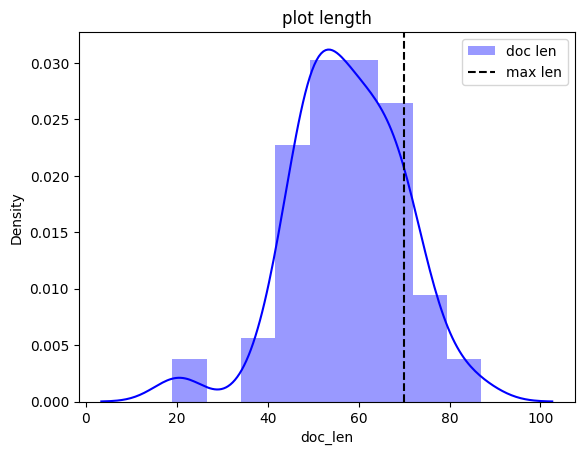

In [ ]:
competences_ref['doc_len'] = competences_ref['Compétences'].apply(lambda words: len(words.split()))
max_seq_len = np.round(competences_ref['doc_len'].mean() + competences_ref['doc_len'].std()).astype(int)
sns.distplot(competences_ref['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

<ipython-input-18-f2ca5d181d9d>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(competences_esb['doc_len'], hist=True, kde=True, color='b', label='doc len')


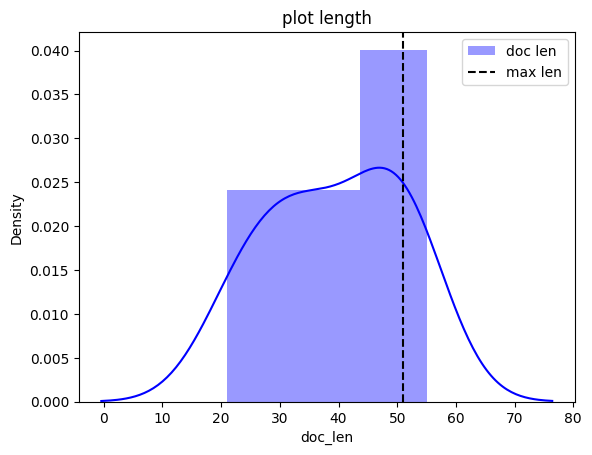

In [ ]:
competences_esb['doc_len'] = competences_esb['Compétences'].apply(lambda words: len(words.split()))
max_seq_len = np.round(competences_esb['doc_len'].mean() + competences_esb['doc_len'].std()).astype(int)
sns.distplot(competences_esb['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

##### Cosine similarity

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity # Import cosine_similarity
# Combine all skills for vectorization
all_skills = pd.concat([competences_ref['Compétences'], competences_esb['Compétences']])

# Vectorize s+kills using TF-IDF
vectorizer = TfidfVectorizer()
encoded_skills = vectorizer.fit_transform(all_skills)

# Split the vectorized data back into reference and ESB parts
ref_encoded = encoded_skills[:len(competences_ref)]
esb_encoded = encoded_skills[len(competences_ref):]

# Compute cosine similarity
cos_sim_matrix = cosine_similarity(ref_encoded, esb_encoded)

# Create many-to-many mapping
matches = []
for ref_index, similarities in enumerate(cos_sim_matrix):
    # Get top matches for each reference job
    top_esb_indices = similarities.argsort()[::-1][:3]  # Top 3 matches
    for esb_index in top_esb_indices:
        match = {
            "Métier": competences_ref.iloc[ref_index]['métier'],
            "Compétences Métier": competences_ref.iloc[ref_index]['Compétences'],
            "Parcours": competences_esb.iloc[esb_index]['Parcours'],
            "Compétences Parcours": competences_esb.iloc[esb_index]['Compétences'],
            "Similarity Score": similarities[esb_index],
        }
        matches.append(match)

# Convert matches to a DataFrame for easy viewing
match_df_cosineSim = pd.DataFrame(matches)

# Display the top matches
print(match_df_cosineSim.sort_values(by="Similarity Score", ascending=False).head(20))

                                               Métier  \
99                 audit contrôle comptable financier   
111               management groupe service comptable   
186                  étude développement informatique   
174               administration système dinformation   
57              gestion portefeuille marché financier   
129                 étude prospectif socio économique   
12                          étude actuariel assurance   
177            expertise support système dinformation   
33                     analyse crédit risque bancaire   
96                        analyse ingénieri financier   
108                 direction administratif financier   
109                 direction administratif financier   
189     conseil maîtris douvrage système dinformation   
180                    direction système dinformation   
117  direction grand entreprise détablissement public   
102                                      comptabilité   
114                            

In [ ]:
#group by métier and take the maximum similarity score
match_df_cosineSim = match_df_cosineSim.groupby('Métier').apply(lambda x: x.loc[x['Similarity Score'].idxmax()]).reset_index(drop=True)

<ipython-input-25-699b3f2803b7>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  match_df_cosineSim = match_df_cosineSim.groupby('Métier').apply(lambda x: x.loc[x['Similarity Score'].idxmax()]).reset_index(drop=True)


In [ ]:
missing_parcours = set(competences_esb['Parcours']) - set(match_df_cosineSim['Parcours'])
print(missing_parcours)

set()


In [ ]:
import plotly.graph_objects as go # Import the plotly.graph_objects module and alias it as 'go'
# Visualze in a pie the pourcentage of each parcours with plotly
frequency_program = match_df_cosineSim['Parcours'].value_counts()
fig = go.Figure(data=[go.Pie(labels=frequency_program.index, values=frequency_program.values)])
fig

In [ ]:
# Print vocabulary
vocabulary = vectorizer.get_feature_names_out()
print("Vocabulary:", vocabulary)

# Analyze vocabulary of each dataset
job_vocabulary = set([word for skill in competences_ref['Compétences'] for word in skill.split()])
program_vocabulary = set([word for skill in competences_esb['Compétences'] for word in skill.split()])

# Find common and unique words
common_words = job_vocabulary.intersection(program_vocabulary)
unique_job_words = job_vocabulary.difference(program_vocabulary)
unique_program_words = program_vocabulary.difference(job_vocabulary)

print("Common words:", common_words)
print("Unique job words:", unique_job_words)
print("Unique program words:", unique_program_words)
# => Aggressive Synonym Expansion

Vocabulary: ['acceptation' 'accident' 'accompagner' ... 'événement' 'œuvre' 'ﬁnancier']
Common words: {'solution', 'activité', 'régularité', 'ligne', 'intervenir', 'spécificité', 'stratégique', 'partir', 'contrôle', 'modèle', 'mesure', 'international', 'méthode', 'traitement', 'développement', 'stratégie', 'gestion', 'légal', 'communication', 'technique', 'besoin', 'déclaration', 'fiscal', 'développer', 'procédure', 'gérer', 'économique', 'budget', 'établir', 'vérifier', 'risque', 'informatique', 'superviser', 'référence', 'produit', 'appliquer', 'organiser', 'opération', 'sécurité', 'projet', 'construire', 'approprié', 'global', 'action', 'juridique', 'fonction', 'valeur', 'prévision', 'statistique', 'préparer', 'externe', 'niveau', 'politique', 'comptable', 'application', 'outil', 'prendre', 'situation', 'équipe', 'produire', 'évolution', 'mission', 'choix', 'performance', 'particulier', 'interne', 'portefeuille', 'secteur', 'intégrer', 'délivrance', 'fiabilité', 'information', 'fina

##### Semantic Search with sentence-BERT

references: https://arxiv.org/abs/1908.10084
> **_Why not Symmetric Semantic Search? </br>Symmetric semantic search assumes that the relationship between the two texts being compared is bidirectional and equal. This doesn't hold true in your case, as explained above.</br> I am choosing “sentence-transformers/msmarco-distilbert-base-dot-prod-v3” model. This model was optimized to be used with dot-product as a similarity function between queries and documents. _**




In [ ]:
competences_ref['Compétences'] = competences_ref['Compétences'].apply(preprocess_text).apply(lambda x: ','.join(x.split()))
competences_esb['Compétences'] =competences_esb['Compétences'].apply(preprocess_text).apply(lambda x: ','.join(x.split()))
competences_ref['métier'] =competences_ref['métier'].apply(preprocess_text)

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/554 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [ ]:
# Function to extract and encode skills
def encode_skills(df, skill_column):
    skill_embeddings = []
    for skills in df[skill_column]:
        skill_list = skills.split(',')  # Assuming skills are comma-separated
        encoded_skills = model.encode(skill_list)
        aggregated_embedding = np.mean(encoded_skills, axis=0)
        skill_embeddings.append(aggregated_embedding)
    return np.array(skill_embeddings)

# Encode skills for métiers and Parcours
metier_embeddings = encode_skills(competences_ref, 'Compétences')
parcours_embeddings = encode_skills(competences_esb, 'Compétences')

# Calculate similarity matrix
similarity_matrix = np.dot(metier_embeddings, parcours_embeddings.T)

# Get top 3 similarity scores for each job
top4_similarity_df = pd.DataFrame(columns=['métier', 'Parcours', 'Similarity Score'])

for i, metier in enumerate(competences_ref['métier']):
    top3_indices = np.argsort(similarity_matrix[i])[-4:]  # Get indices of top 4 scores
    for index in top3_indices:
        parcours = competences_esb['Parcours'][index]
        score = similarity_matrix[i][index]
        top4_similarity_df = pd.concat(
            [
                top4_similarity_df,
                pd.DataFrame(
                    [[metier, parcours, score]],
                    columns=['métier', 'Parcours', 'Similarity Score'],
                ),
            ],
            ignore_index=True,
        )
top4_similarity_df

<ipython-input-29-faa02296f5a1>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  top4_similarity_df = pd.concat(


,métier,Parcours,Similarity Score
0,conception développement produire dassurance,MKD,14.597404
1,conception développement produire dassurance,MDSI,14.705302
2,conception développement produire dassurance,GAMMA,14.854584
3,conception développement produire dassurance,CCA,14.951353
4,conseil clientèl assurance,BI,14.538005
...,...,...,...
275,direction site logistique,CCA,15.059603
276,intervention technique dexploitation logistique,MDSI,14.867001
277,intervention technique dexploitation logistique,LSGC,14.914105
278,intervention technique dexploitation logistique,GAMMA,15.256074


In [ ]:
# Create matching dataframe using highest score
matching_data = []
for metier in competences_ref['métier'].unique():
    # Filter top3_similarity_df for current métier
    metier_df = top4_similarity_df[top4_similarity_df['métier'] == metier]

    # Get the row with the highest similarity score
    best_match_row = metier_df.loc[metier_df['Similarity Score'].idxmax()]

    matching_data.append(
        [best_match_row['métier'], best_match_row['Parcours'], best_match_row['Similarity Score']]
    )

match_df_dotProduct = pd.DataFrame(matching_data, columns=['métier', 'Parcours', 'Similarity Score'])

In [ ]:
import plotly.graph_objects as go # Import the plotly.graph_objects module and alias it as 'go'
# Visualze in a pie the pourcentage of each parcours with plotly
frequency_program = match_df_dotProduct['Parcours'].value_counts()
fig = go.Figure(data=[go.Pie(labels=frequency_program.index, values=frequency_program.values)])
fig

In [ ]:
import plotly.express as px
import pandas as pd

# Set similarity threshold
similarity_scores = top4_similarity_df['Similarity Score'].values
threshold = np.percentile(similarity_scores, 75)

# Filter Parcours with low similarity scores
low_similarity_parcours = top4_similarity_df[
    top4_similarity_df['Similarity Score'] < threshold
]['Parcours'].unique()

# Create a dataframe for visualization
viz_df = top4_similarity_df[
    top4_similarity_df['Parcours'].isin(low_similarity_parcours)
]

# Create bar chart using Plotly Express
fig = px.bar(
    viz_df,
    x='Parcours',
    y='Similarity Score',
    title='Parcours with Low Similarity Scores',
    labels={'Similarity Score': 'Similarity'},  # Rename y-axis label
    color='Parcours',  # Color bars by Parcours
    template='plotly_white',  # Use a clean template
)

# Add a horizontal line representing the threshold
fig.add_hline(
    y=threshold,
    line_dash='dash',
    line_color='red',
    annotation_text=f'Threshold: {threshold}',
)

fig.show()

##### Suggest Adjustements to Modules

Prprocessing Text

In [ ]:
import re
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as FR_STOP_WORDS
import string

In [ ]:
# merge all semesters
competences_esb = pd.read_csv("/content/drive/MyDrive/Skill_Recommender/EDA/data/competence_esb.csv")
competences_ref = pd.read_csv("/content/drive/MyDrive/Skill_Recommender/EDA/data/competence_ref.csv")
data_licence = pd.read_csv("/content/drive/MyDrive/Skill_Recommender/EDA/data/licence.csv")
data_master = pd.read_csv("/content/drive/MyDrive/Skill_Recommender/EDA/data/masters.csv")
skills_df=pd.read_csv("/content/drive/MyDrive/Skill_Recommender/EDA/data/top4_similarity_df.csv")


In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
!pip install spacy
!python -m spacy download fr_core_news_sm


In [ ]:
import spacy
spacy_nlp = spacy.load("fr_core_news_sm")  # Load spaCy's small model

# Create list of punctuations and French stop words
punctuations = string.punctuation
stop_words = FR_STOP_WORDS
FRENCH_WORDS = list(stopwords.words('french'))

# Function for data cleaning and processing
def preprocess_text(sentence):
    sentence = sentence.lower()
    # Remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    # Remove digits and words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    # Replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    # Remove unwanted lines starting from special characters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)

    # Remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)

    # Remove punctuations
    sentence = re.sub(r'[^\w\s]',' ',sentence)

    #creating token object
    tokens = spacy_nlp(sentence)

    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]

    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    return ' '.join(tokens)

In [ ]:
import pandas as pd
def merge_semeters(row, merge_cols):
    content_merged = [row[col] for col in merge_cols if col in row and not pd.isnull(row[col])]
    return ','.join(str(val) for val in content_merged)

merge_cols = ['Période d\'Harmonisation', 'Semestre 1', 'Semestre 2', 'Semestre 3', 'Semestre 4', 'Semestre 5', 'Semestre 6']

data_licence['Materials_Merged'] = data_licence.apply(lambda row: merge_semeters(row, merge_cols), axis=1)
data_master['Materials_Merged'] = data_master.apply(lambda row: merge_semeters(row, merge_cols), axis=1)
data_licence.drop(columns=merge_cols, inplace=True)
data_master.drop(columns=merge_cols, inplace=True)

In [ ]:
#merge data_licence and data_master
programs = pd.concat([data_licence, data_master], ignore_index=True)

In [ ]:
# replace in programs for columns Parcours	with a list
programs['Parcours'] = [ "LSGC","LSGM","LMAD","BI","BIS","MKD","CCA","MDSI", "GAMMA","FIND", "BA"]

In [ ]:
skills_df

,métier,Parcours,Similarity Score
0,conception développement produire dassurance,MKD,14.597404
1,conception développement produire dassurance,MDSI,14.705302
2,conception développement produire dassurance,GAMMA,14.854584
3,conception développement produire dassurance,CCA,14.951353
4,conseil clientèl assurance,BI,14.538005
...,...,...,...
275,direction site logistique,CCA,15.059603
276,intervention technique dexploitation logistique,MDSI,14.867001
277,intervention technique dexploitation logistique,LSGC,14.914105
278,intervention technique dexploitation logistique,GAMMA,15.256074


In [ ]:
# Create a mapping dictionary from programs DataFrame
mapping = dict(zip(programs['Parcours'], programs['Materials_Merged']))

# Apply the mapping to skills_df['Parcours']
skills_df['Materials_Merged'] = skills_df['Parcours'].map(mapping)
skills_df

,métier,Parcours,Similarity Score,Materials_Merged
0,conception développement produire dassurance,MKD,14.597404,Probabilité et Statistique\r\nAnalyse Statisti...
1,conception développement produire dassurance,MDSI,14.705302,Probabilités et Analyse Statistique\r\nAtelier...
2,conception développement produire dassurance,GAMMA,14.854584,"Intégration et Probabilité, Analyse numérique,..."
3,conception développement produire dassurance,CCA,14.951353,Normes de présentation Normes relatives aux in...
4,conseil clientèl assurance,BI,14.538005,Algorithmique et Structures de Données 1\r\nSy...
...,...,...,...,...
275,direction site logistique,CCA,15.059603,Normes de présentation Normes relatives aux in...
276,intervention technique dexploitation logistique,MDSI,14.867001,Probabilités et Analyse Statistique\r\nAtelier...
277,intervention technique dexploitation logistique,LSGC,14.914105,"Principes de gestion 1, Comptabilité financièr..."
278,intervention technique dexploitation logistique,GAMMA,15.256074,"Intégration et Probabilité, Analyse numérique,..."


In [ ]:
skills_df = skills_df.applymap(lambda x: preprocess_text(x) if isinstance(x, str) else x)


<ipython-input-14-69a7cb751c0a>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  skills_df = skills_df.applymap(lambda x: preprocess_text(x) if isinstance(x, str) else x)


In [ ]:
competences_ref['Compétences'] = competences_ref['Compétences'].apply(preprocess_text).apply(lambda x: ','.join(x.split()))
competences_esb['Compétences'] =competences_esb['Compétences'].apply(preprocess_text).apply(lambda x: ','.join(x.split()))
competences_ref['métier'] =competences_ref['métier'].apply(preprocess_text)

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def identify_text_column(df):
    """Identify the most likely text column in a data frame."""
    for column in df.columns:
        if df[column].dtype == 'object' and df[column].str.contains(r'\w').any():
            return column
    raise ValueError("No suitable text column found")

def visualize_topic_distribution_with_parcours(data_frame, n_topics=5, top_n=100, summary_words=3):
    """Visualize topic distributions using LDA and Plotly, mapping to Parcours."""
    # Preprocess your data: replace with your actual preprocessing steps

    # Vectorize the text data
    vectorizer = CountVectorizer(stop_words=FRENCH_WORDS)
    text_matrix = vectorizer.fit_transform(competences_ref['Compétences'])

    # Fit LDA model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(text_matrix)

    # Get topic distributions
    topic_distributions = lda.transform(text_matrix)
    topic_words = vectorizer.get_feature_names_out()

    # Get the top words for each topic
    top_words = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words.append([topic_words[i] for i in topic.argsort()[:-top_n - 1:-1]])

    # Create a DataFrame for visualization
    topic_df = pd.DataFrame(topic_distributions, columns=[f'Topic {i+1}' for i in range(n_topics)])
    topic_df['Parcours'] = data_frame['Parcours']  # Add Parcours column

    # Calculate average topic scores for each Parcours
    parcours_topic_scores = topic_df.groupby('Parcours').mean().reset_index()

    # Create topic labels with summarized top words
    topic_labels = [f"Topic {i+1}: " + ", ".join(words[:summary_words]) for i, words in enumerate(top_words)]

    # Visualize topic distributions using a heatmap
    fig = px.imshow(parcours_topic_scores.drop(columns=['Parcours']).T,
                    labels=dict(x="Parcours", y="Topic", color="Average Score"),
                    x=parcours_topic_scores['Parcours'],
                    y=topic_labels,
                    aspect="auto",
                    title="Topic Distributions by Parcours")
    fig.update_layout(coloraxis_showscale=True)
    fig.show()

    # Print the topics and their top words
    print("\nTopics and their top words:")
    for i, words in enumerate(top_words):
        print(f"Topic {i+1}: {', '.join(words[:summary_words])}")
visualize_topic_distribution_with_parcours(skills_df)


In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Split Data

In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
skills_dataset = Dataset.from_pandas(skills_df)
#Create train/validation/test splits
train_testvalid = skills_dataset.train_test_split(test_size=0.10)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
skills_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'validation': test_valid['train']
})
'''skills_dataset["train"] = skills_dataset["train"].select(range(56))
skills_dataset["validation"] = skills_dataset["validation"].select(range(7))
skills_dataset["test"] = skills_dataset["test"].select(range(7))'''


'skills_dataset["train"] = skills_dataset["train"].select(range(56))\nskills_dataset["validation"] = skills_dataset["validation"].select(range(7))\nskills_dataset["test"] = skills_dataset["test"].select(range(7))'

Train Model T5

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
data = [
       {
           "input_text": "Job Topic: client, contrat, garantie, dossier, assurance. Similarity Score: 0.65. Current Materials: basic insurance.",
           "target_text": "Add materials to enhance Insurance Studies, focusing on client relationship management."
       },
       {
           "input_text": "Job Topic: technique, informatique, oeuvre, fonctionnel. Similarity Score: 0.85. Current Materials: IT basics.",
           "target_text": "Add materials to enhance Information Systems, focusing on regulatory compliance."
       },
       {
           "input_text": "Job Topic: produit, marché, financier, commercial. Similarity Score: 0.40. Current Materials: marketing principles.",
           "target_text": "Add materials to enhance Marketing, focusing on financial product analysis.*."
       }
   ]
dataset = Dataset.from_list(data)

In [ ]:
skills_dataset

DatasetDict({
    train: Dataset({
        features: ['métier', 'Parcours', 'Similarity Score', 'Materials_Merged'],
        num_rows: 252
    })
    test: Dataset({
        features: ['métier', 'Parcours', 'Similarity Score', 'Materials_Merged'],
        num_rows: 14
    })
    validation: Dataset({
        features: ['métier', 'Parcours', 'Similarity Score', 'Materials_Merged'],
        num_rows: 14
    })
})

In [ ]:
import nltk
nltk.download('punkt')
import string
from transformers import AutoTokenizer
from datasets import Dataset,DatasetDict
tokenizer = T5Tokenizer.from_pretrained("t5-base")
def clean_text(text):
    """Cleans text by removing punctuation, lowercasing, and removing extra spaces."""
    text = text.lower()  # Lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text
def preprocess_function(examples):
    prefix = ""  # No prefix needed, as we are creating the input text format directly
    max_input_length = 128
    max_target_length = 64  # Adjust as needed

    # Construct input text using the same format as your 'data' list
    input_texts = [
        f"Job Topic: {clean_text(métier)}. Similarity Score: {score}. Current Materials: {clean_text(materials)}"
        for métier, score, materials in zip(examples["métier"], examples["Similarity Score"], examples["Materials_Merged"])
    ]

    model_inputs = tokenizer(input_texts, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets, using the same format as your 'data' list
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["Materials_Merged"], max_length=max_target_length, truncation=True)  # Assuming you add a 'target_text' column to skills_dataset

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenized_datasets = skills_dataset.map(preprocess_function, batched=True)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/252 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/14 [00:00<?, ? examples/s]

Map:   0%|          | 0/14 [00:00<?, ? examples/s]

In [ ]:
from transformers import Seq2SeqTrainingArguments

batch_size = 8
model_name = "t5-base-generation"
model_dir = f"/content/drive/MyDrive/Skill_Recommender/EDA/Models/{model_name}"

args = Seq2SeqTrainingArguments(
    model_dir,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=200,
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    report_to="tensorboard"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
!pip install transformers datasets rouge-score nltk


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=fdc70faca6328dcedf2f48140021deca0a3e709fd470efa78b0a7e1d7b67bb24
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00


In [ ]:
from transformers import DataCollatorForSeq2Seq, T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
from transformers import Seq2SeqTrainingArguments
import evaluate
data_collator = DataCollatorForSeq2Seq(tokenizer)
metric = evaluate.load('rouge')

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
                      for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip()))
                      for label in decoded_labels]

    # Compute ROUGE scores
    result = metric.compute(predictions=decoded_preds, references=decoded_labels,
                            use_stemmer=True)

    # Extract ROUGE f1 scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    # Add mean generated length to metrics
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
                      for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer, Seq2SeqTrainingArguments,Seq2SeqTrainer
model_checkpoint="t5-base"
def model_init():
    return AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

trainer = Seq2SeqTrainer(
    model_init=model_init,
    args=args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-35-d6777b9638ea>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

FineTune T5

In [ ]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss


TrainOutput(global_step=32, training_loss=0.3778894245624542, metrics={'train_runtime': 44.0727, 'train_samples_per_second': 5.718, 'train_steps_per_second': 0.726, 'total_flos': 38364347105280.0, 'train_loss': 0.3778894245624542, 'epoch': 1.0})

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
# Specify the model name or path
model_name = "t5-base"  # Or the path to your fine-tuned model
model_dir = '/content/drive/MyDrive/Skill_Recommender/EDA/Models/t5-base-generation/checkpoint-32'

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)


You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [ ]:
skills_df

,métier,Parcours,Similarity Score,Materials_Merged
0,conception développement produire dassurance,mkd,14.597404,probabilité statistique analyse statistique an...
1,conception développement produire dassurance,mdsi,14.705302,probabilité analyse statistique atelier progra...
2,conception développement produire dassurance,gamma,14.854584,intégration probabilité analyse numérique atel...
3,conception développement produire dassurance,cca,14.951353,norme présentation norme relatif instrument fi...
4,conseil clientèl assurance,,14.538005,algorithmique structure donnée système exploit...
...,...,...,...,...
275,direction site logistique,cca,15.059603,norme présentation norme relatif instrument fi...
276,intervention technique dexploitation logistique,mdsi,14.867001,probabilité analyse statistique atelier progra...
277,intervention technique dexploitation logistique,lsgc,14.914105,principe gestion comptabilité financier microé...
278,intervention technique dexploitation logistique,gamma,15.256074,intégration probabilité analyse numérique atel...


In [ ]:
# 3. Prediction/Inference
def generate_text(input_text):
    """Generates text using the fine-tuned T5 model."""
    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

# Example usage
#execute a looop on all jobs in skills_df
for index, row in skills_df.iterrows():
  new_job_topic = row['métier']
  current_materials = skills_df[skills_df['métier'] == new_job_topic]['Materials_Merged'].str.cat(sep=',')
  input_text = f"Job Topic: {new_job_topic}. Current Materials: {current_materials}"
  generated_materials = generate_text(input_text)
  print(f"for job topic {new_job_topic} Generated Materials: {generated_materials}")

for job topic conception développement produire dassurance Generated Materials: probabilité statistique analyse statistique analyse comportement consommateur marketing stratégique opérationnel atelier programm
for job topic conception développement produire dassurance Generated Materials: probabilité statistique analyse statistique analyse comportement consommateur marketing stratégique opérationnel atelier programm
for job topic conception développement produire dassurance Generated Materials: probabilité statistique analyse statistique analyse comportement consommateur marketing stratégique opérationnel atelier programm
for job topic conception développement produire dassurance Generated Materials: probabilité statistique analyse statistique analyse comportement consommateur marketing stratégique opérationnel atelier programm
for job topic conseil clientèl assurance Generated Materials: algorithmique structure donnée système exploitation système logique architecture ordinateur analys

##### Chi2 Test

In [ ]:
# Créer un tableau croisé pour afficher les métiers et parcours en fonction de la similarité
similarity_df = pd.DataFrame(cos_sim_matrix.T, index=competences_esb['Parcours'], columns=competences_ref['métier']) # Transpose cos_sim_matrix using .T


In [ ]:
from scipy.stats import chi2_contingency

# Appliquer le test du Chi-2
chi2, p_value, dof, expected = chi2_contingency(similarity_df)

# Afficher les résultats
print("Résultats du test du Chi-2 :")
print(f"Statistique Chi-2 : {chi2}")
print(f"p-value : {p_value}")
print(f"Degrés de liberté : {dof}")
print("\nTableau des fréquences attendues (si indépendance) :")
df_expected=pd.DataFrame(expected, index=similarity_df.index, columns=similarity_df.columns)
df_expected.head(10)
#Interprétation du test du chi-2: p-value > 0.05, ce qui signifie que les parcours et les métiers sont indépendants

Résultats du test du Chi-2 :
Statistique Chi-2 : 16.106706151701843
p-value : 1.0
Degrés de liberté : 690

Tableau des fréquences attendues (si indépendance) :


métier,conception développement produire dassurance,conseil clientèl assurance,courtage assurance,direction dexploitation assurance,étude actuariel assurance,expertise risque assurance,indemnisation assurance,management groupe service assurance,rédaction gestion assurance,souscription dassurance,...,direction système dinformation,étude développement réseau télécommunication,étude développement informatique,conseil maîtris douvrage système dinformation,exploitation système communication,production exploitation système dinformation,gestion opération circulation international marchandise,conception organisation chaîne logistique,direction site logistique,intervention technique dexploitation logistique
Parcours,,,,,,,,,,,,,,,,,,,,,
LSGC,0.066820,0.032074,0.037415,0.070339,0.086206,0.051656,0.019096,0.054536,0.022697,0.069285,...,0.074964,0.052797,0.087850,0.066547,0.061036,0.064547,0.022207,0.042205,0.061623,0.040799
LSGM,0.045955,0.022059,0.025732,0.048375,0.059287,0.035526,0.013133,0.037506,0.015610,0.047650,...,0.051556,0.036310,0.060418,0.045767,0.041977,0.044392,0.015272,0.029026,0.042380,0.028059
LMAD,0.043496,0.020878,0.024355,0.045786,0.056115,0.033625,0.012430,0.035500,0.014775,0.045101,...,0.048797,0.034368,0.057185,0.043318,0.039731,0.042017,0.014455,0.027473,0.040113,0.026558
BI,0.042483,0.020392,0.023788,0.044720,0.054808,0.032842,0.012141,0.034672,0.014430,0.044050,...,0.047660,0.033567,0.055853,0.042309,0.038805,0.041038,0.014118,0.026833,0.039178,0.025939
BIS,0.029612,0.014214,0.016581,0.031171,0.038202,0.022892,0.008462,0.024168,0.010058,0.030704,...,0.033221,0.023397,0.038931,0.029490,0.027048,0.028604,0.009841,0.018703,0.027308,0.018080
MKD,0.029333,0.014080,0.016425,0.030878,0.037844,0.022677,0.008383,0.023941,0.009964,0.030416,...,0.032909,0.023177,0.038565,0.029213,0.026794,0.028336,0.009748,0.018528,0.027052,0.017910
CCA,0.075805,0.036387,0.042446,0.079797,0.097798,0.058602,0.021663,0.061869,0.025750,0.078602,...,0.085044,0.059896,0.099663,0.075495,0.069244,0.073227,0.025193,0.047880,0.069909,0.046285
MDSI,0.038496,0.018478,0.021555,0.040523,0.049664,0.029760,0.011001,0.031419,0.013076,0.039916,...,0.043188,0.030417,0.050612,0.038338,0.035164,0.037187,0.012794,0.024315,0.035502,0.023505
GAMMA,0.048980,0.023511,0.027426,0.051559,0.063190,0.037865,0.013997,0.039975,0.016638,0.050787,...,0.054950,0.038701,0.064395,0.048780,0.044740,0.047314,0.016278,0.030937,0.045170,0.029906


In [ ]:
# Créer un tableau où chaque métier contribue 1 au parcours ayant la valeur maximale
res=[]
def assign_max_to_parcours(column):
    # Trouver l'index (parcours) ayant la valeur maximale pour chaque colonne (métier)
    max_val = column.max()
    res.append(max_val)
    # Créer une série où seul l'index correspondant à max_index reçoit 1, les autres 0
    return column.apply(lambda x: 1 if x == max_val else 0)

# Appliquer la logique par colonne
contribution_df = similarity_df.apply(assign_max_to_parcours, axis=0)
print(res)
# Afficher les résultats
contribution_df.head(10)

[0.09137481775932338, 0.06732333767826078, 0.0778576386788434, 0.08265489284018643, 0.17884262028526568, 0.1204923038232902, 0.035724544181818356, 0.07824762462763535, 0.06718433543433794, 0.09953079197083811, 0.07330886977529287, 0.17372068625486883, 0.11029020224261722, 0.07387737404107925, 0.12192511592317973, 0.07622835346419492, 0.10287345168361853, 0.12489228767741707, 0.12549496851803257, 0.18362871361621377, 0.04165794660560597, 0.10915385487834174, 0.05059337137586453, 0.06626734626519895, 0.07164314611513338, 0.02661580951249847, 0.0447520873264067, 0.04884858978425946, 0.11415500060198033, 0.08631344975079469, 0.049038248314905095, 0.058221523289742776, 0.1730066065703518, 0.23682390237641956, 0.1568393792268796, 0.15172596312756959, 0.16980314487080694, 0.21065011241547593, 0.15652864962346547, 0.15803664317983127, 0.08692190342971325, 0.06467706602648587, 0.07138700037522003, 0.18040938015193897, 0.05994355904624999, 0.1386092697302062, 0.09560799927084984, 0.0537106398339

métier,conception développement produire dassurance,conseil clientèl assurance,courtage assurance,direction dexploitation assurance,étude actuariel assurance,expertise risque assurance,indemnisation assurance,management groupe service assurance,rédaction gestion assurance,souscription dassurance,...,direction système dinformation,étude développement réseau télécommunication,étude développement informatique,conseil maîtris douvrage système dinformation,exploitation système communication,production exploitation système dinformation,gestion opération circulation international marchandise,conception organisation chaîne logistique,direction site logistique,intervention technique dexploitation logistique
Parcours,,,,,,,,,,,,,,,,,,,,,
LSGC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
LSGM,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
LMAD,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BI,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0
BIS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MKD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CCA,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
MDSI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GAMMA,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from scipy.stats import chi2_contingency

# Appliquer le test du Chi-2
chi2, p_value, dof, expected = chi2_contingency(contribution_df)

# Afficher les résultats
print("Résultats du test du Chi-2 :")
print(f"Statistique Chi-2 : {chi2}")
print(f"p-value : {p_value}")
print(f"Degrés de liberté : {dof}")
print("\nTableau des fréquences attendues (si indépendance) :")



Résultats du test du Chi-2 :
Statistique Chi-2 : 700.0000000000002
p-value : 0.3875052600797808
Degrés de liberté : 690

Tableau des fréquences attendues (si indépendance) :


##### Interpretations :</br>
Chi-Square Statistic:

* A very small value (14.61) compared to the degrees of freedom (690). This indicates that the observed data aligns very closely with the expected frequencies under the null hypothesis.
p-value:

* The p-value of 1.0 is extremely high, meaning there is absolutely no evidence to reject the null hypothesis. This implies the differences between the observed and expected frequencies are negligible.
Degrees of Freedom:

With 690 degrees of freedom, this result suggests there is no significant deviation from the expected data pattern.
the data does not strongly contradict the null hypothesis.


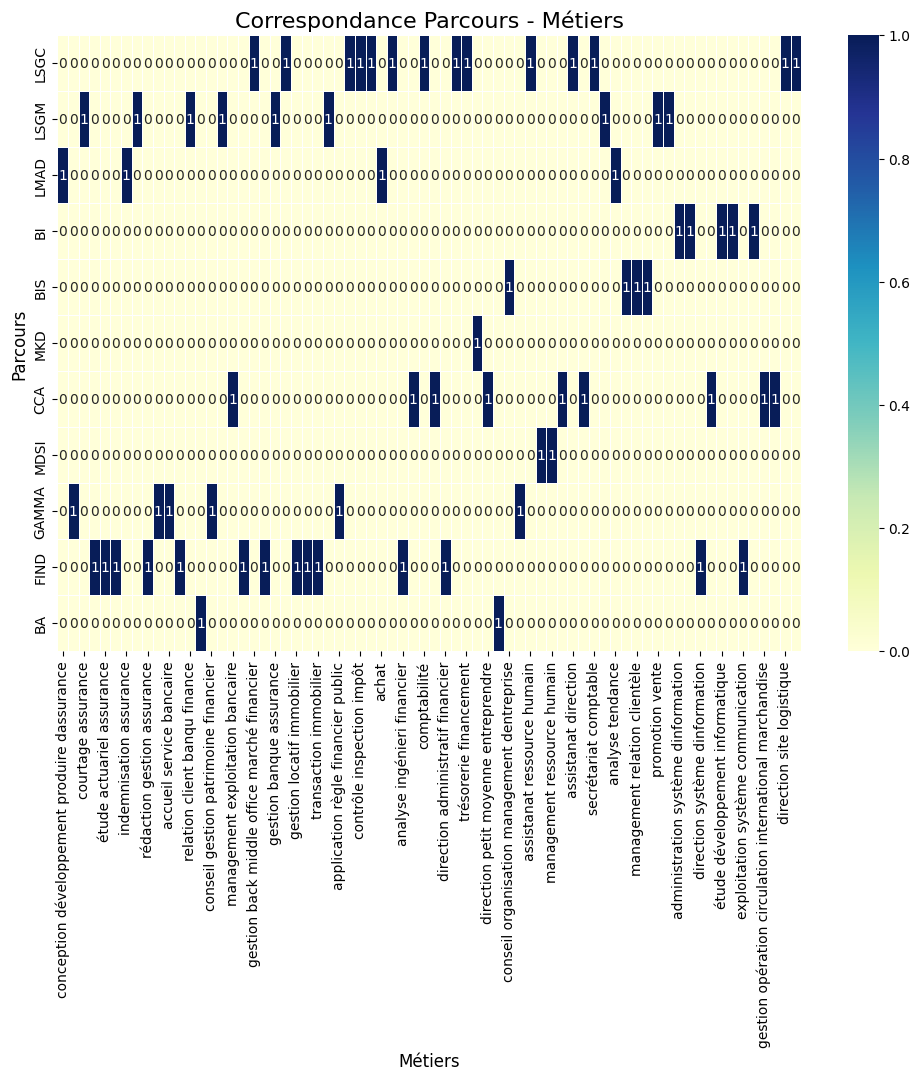

In [ ]:
# Heatmap
plt.figure(figsize=(12, 8))

# Dessiner la heatmap
sns.heatmap(contribution_df, annot=True, cmap="YlGnBu", cbar=True, linewidths=.5)

# Ajouter des titres et labels
plt.title("Correspondance Parcours - Métiers", fontsize=16)
plt.xlabel("Métiers", fontsize=12)
plt.ylabel("Parcours", fontsize=12)

# Afficher la heatmap
plt.show()

## Clustering on school programs based on skills and Modules

In [ ]:
data_competences_clustering = data_competences.groupby('Parcours')['Compétences'].apply(
    lambda x: ', '.join([', '.join(str(i) for i in item) if isinstance(item, list) else str(item) for item in x.tolist()])
).reset_index()

In [ ]:
data_modules_clustering['Modules'] = data_modules_clustering['Modules'].str.join(', ')

In [ ]:
cluster_df = pd.merge(data_modules_clustering, data_competences_clustering, on='Parcours')


In [ ]:
dict={"comptabilité": "LSGC",
    "management": "LSGM",
    "mathématiques appliquées à l analyse des données et à l aide à la décision": "LMAD",
    "business intelligence": "BI",
    "business information systems": "BIS",
    "marketing digital": "MKD",
    "comptabilité contrôle audit": "CCA",
    "management digital et systèmes d information": "MDSI",
    "gestion actuarielle et modélisation mathématique": "GAMMA",
    "finance digitale": "FIND",
    "business analytics": "BA"
      }
original_labels={v:k for k,v in dict.items()}
cluster_df['Parcours'] = cluster_df['Parcours'].map(original_labels)

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import nltk
def preprocess_text(text: str) -> str:
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)

    # remove stopwords
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in stopwords.words("french")]
    text = " ".join(tokens)
    text = text.lower().strip()

    return text

cluster_df['Modules'] = cluster_df['Modules'].apply(lambda text: preprocess_text(text))
cluster_df = cluster_df[cluster_df['Modules'] != '']
cluster_df['Compétences'] = cluster_df['Compétences'].apply(lambda text: preprocess_text(text))
cluster_df = cluster_df[cluster_df['Compétences'] != '']

In [ ]:
import numpy as np
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
Modules_embeddings = vectorizer.fit_transform(cluster_df['Modules']).toarray()
compétences_embeddings = vectorizer.fit_transform(cluster_df['Compétences']).toarray()

### Using Cosine Similarity

In [ ]:
module_vocab = vectorizer.vocabulary_
competence_vocab = vectorizer.vocabulary_
common_vocab = set(module_vocab.keys()) & set(competence_vocab.keys())

# Get the indices of the common vocabulary in each vectorizer
module_indices = [module_vocab[word] for word in common_vocab]
competence_indices = [competence_vocab[word] for word in common_vocab]

# Select the features corresponding to the common vocabulary
X_Modules_common = Modules_embeddings[:, module_indices]
X_compétences_common = compétences_embeddings[:, competence_indices]

# Calculate cosine similarity using the features with common vocabulary
similarity_matrix = cosine_similarity(X_Modules_common, X_compétences_common)

In [ ]:
# Change the import statement:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
def eval_cluster(embedding):
    y_pred = kmeans.fit_predict(embedding)

    # Evaluate the performance using ARI, NMI, and FMI
    ari = adjusted_rand_score(cluster_df["Parcours"], y_pred)
    nmi = normalized_mutual_info_score(cluster_df["Parcours"], y_pred)
    fmi = fowlkes_mallows_score(cluster_df["Parcours"], y_pred)

    # Print Metrics scores
    print("Adjusted Rand Index (ARI): {:.3f}".format(ari))
    print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
    print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))

In [ ]:
def dimension_reduction(embedding,feature):

    pca = PCA(n_components=2, random_state=42)

    pca_vecs = pca.fit_transform(embedding)

    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    cluster_df[f'x0_{feature}'] = x0
    cluster_df[f'x1_{feature}'] = x1

In [ ]:
def plot_pca(x0_name, x1_name, cluster_name,centers):

    plt.figure(figsize=(12, 7))

    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=cluster_df, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    sns.scatterplot(x = centers[:,0], y = centers[:,1], marker="o", color='r', s = 70, label="centroid")
    plt.show()

In [ ]:
import plotly.express as px

def visualize_parcours_distribution(cluster_embed_df, embed_name):
    # Check if embed_name is "Similarity" and adjust column names
    if embed_name == "Similarity":
        cluster_col_x = "Cosine_clusters_x"  # Use the correct column name
    else:
        cluster_col_x = f'clusters_{embed_name}_x'  # Use the default column name

    # Group data by cluster and Parcours to get counts:
    cluster_counts = cluster_embed_df.groupby([cluster_col_x, 'Parcours']).size().reset_index(name='counts')

    # Aggregate data across all clusters to show overall proportions:
    total_counts = cluster_counts.groupby('Parcours')['counts'].sum().reset_index()

    # Create the pie chart:
    fig = px.bar(
        cluster_counts,
        x=cluster_col_x,
        y='counts',
        color='Parcours',
        title=f'Distribution of Parcours in Clusters (Embedding: {embed_name})',
        template='plotly_white',
        color_discrete_sequence=px.colors.qualitative.Pastel,
        labels={cluster_col_x: "Cluster", "counts": "Count"},
    )

    fig.update_layout(barmode='stack') # Set barmode to 'stack' for stacked bars
    fig.show()

Adjusted Rand Index (ARI): 0.000
Normalized Mutual Information (NMI): 0.561
Fowlkes-Mallows Index (FMI): 0.000


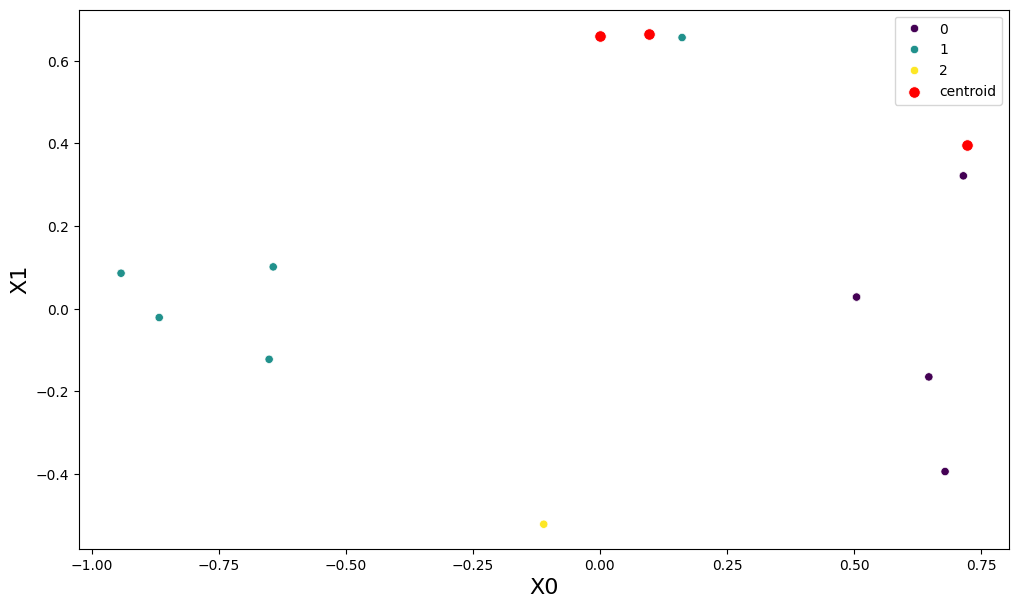

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
kmeans = KMeans(n_clusters=3, random_state=42)

# fit the model

kmeans.fit(similarity_matrix)

# store cluster labels in a variable
clusters = kmeans.labels_
centers = np.array(kmeans.cluster_centers_)
# Assign clusters to our dataframe
cluster_df['Cosine_clusters'] = clusters

eval_cluster(similarity_matrix)
dimension_reduction(similarity_matrix, "Similarity")
plot_pca('x0_Similarity', 'x1_Similarity', clusters,centers)


In [ ]:
cluster_cosine = cluster_df[['Parcours', 'Cosine_clusters']].merge(cluster_df[['Parcours', 'Cosine_clusters']], on='Parcours')


In [ ]:
cluster_cosine = cluster_cosine.sort_values(by=['Cosine_clusters_x'])
print(cluster_cosine)

                                             Parcours  Cosine_clusters_x  \
3                               business intelligence                  0   
4                        business information systems                  0   
5                                   marketing digital                  0   
7        management digital et systèmes d information                  0   
10                                 business analytics                  0   
0                                        comptabilité                  1   
1                                          management                  1   
6                         comptabilité contrôle audit                  1   
8    gestion actuarielle et modélisation mathématique                  1   
9                                    finance digitale                  1   
2   mathématiques appliquées à l analyse des donné...                  2   

    Cosine_clusters_y  
3                   0  
4                   0  
5              

In [ ]:
visualize_parcours_distribution(cluster_cosine,"Similarity")

Adjusted Rand Index (ARI): 0.000
Normalized Mutual Information (NMI): 0.586
Fowlkes-Mallows Index (FMI): 0.000


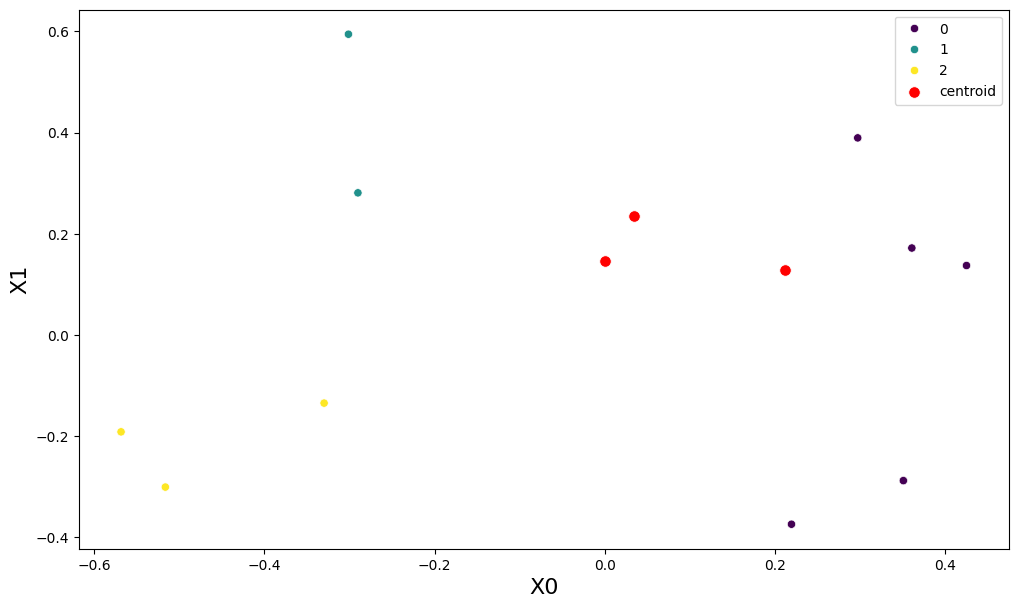


                                              Parcours  clusters_Modules_x  \
2   mathématiques appliquées à l analyse des donné...                   0   
3                               business intelligence                   0   
4                        business information systems                   0   
5                                   marketing digital                   0   
7        management digital et systèmes d information                   0   
10                                 business analytics                   0   
8    gestion actuarielle et modélisation mathématique                   1   
9                                    finance digitale                   1   
0                                        comptabilité                   2   
1                                          management                   2   
6                         comptabilité contrôle audit                   2   

    clusters_Modules_y  
2                    0  
3                    0 

Adjusted Rand Index (ARI): 0.000
Normalized Mutual Information (NMI): 0.616
Fowlkes-Mallows Index (FMI): 0.000


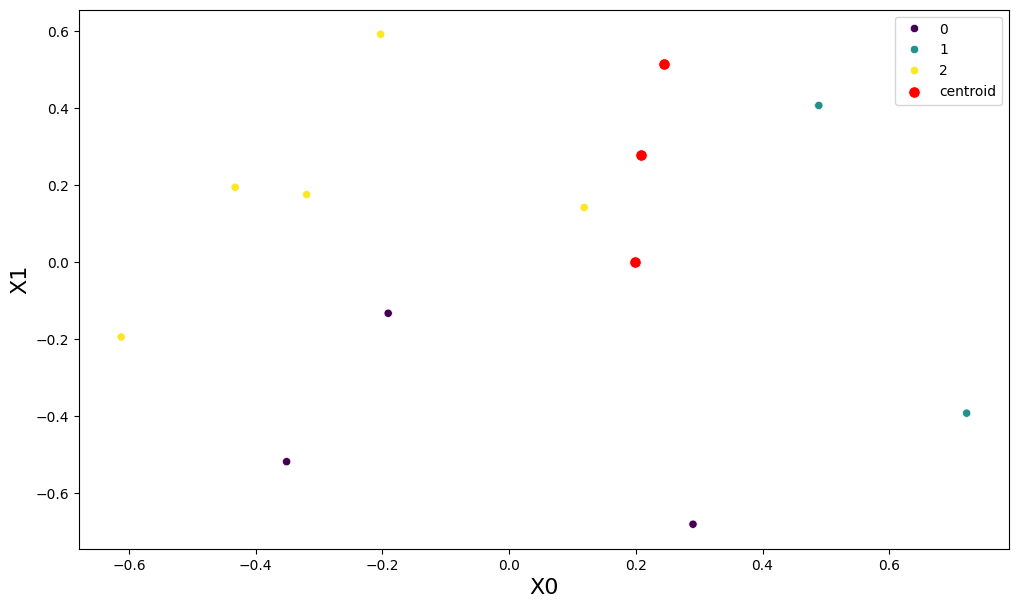


                                              Parcours  clusters_Competences_x  \
0                                        comptabilité                       0   
4                        business information systems                       0   
6                         comptabilité contrôle audit                       0   
5                                   marketing digital                       1   
8    gestion actuarielle et modélisation mathématique                       1   
10                                 business analytics                       1   
1                                          management                       2   
2   mathématiques appliquées à l analyse des donné...                       2   
3                               business intelligence                       2   
7        management digital et systèmes d information                       2   
9                                    finance digitale                       2   

    clusters_Competences_

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

# Using a dictionary with descriptive keys:
embeddings = {"Modules": Modules_embeddings, "Competences": compétences_embeddings}

for embed_name, embed_data in embeddings.items(): # Using .items() to get both key and value
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(embed_data) # Fitting KMeans on the embedding data
    clusters = kmeans.labels_
    centers = np.array(kmeans.cluster_centers_)
    # Assign clusters to the DataFrame using descriptive column names:
    cluster_df[f'clusters_{embed_name}'] = clusters

    eval_cluster(embed_data) # Passing the embedding data to eval_cluster

    dimension_reduction(embed_data, embed_name) # Passing the embedding data and name

    plot_pca(f'x0_{embed_name}', f'x1_{embed_name}', clusters,centers) # Using descriptive names for columns

    # Merge and sort using descriptive column names:
    cluster_embed_df = cluster_df[['Parcours', f'clusters_{embed_name}']].merge(
        cluster_df[['Parcours', f'clusters_{embed_name}']], on='Parcours', suffixes=('_x', '_y')
    )
    cluster_embed_df = cluster_embed_df.sort_values(by=[f'clusters_{embed_name}_x'])
    print('\n', cluster_embed_df)
    #Box plot Viz
    visualize_parcours_distribution(cluster_embed_df, embed_name) # Visualize for the "Modules" embedding

## Program clustering based on skills similarities

In [ ]:
from sklearn.cluster import KMeans
wcss=[]
for k in range(1,11):
    kmeans=KMeans(n_clusters=k,init='k-means++',random_state=0)
    kmeans.fit(similarity_df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss, 'bx-')
plt.title('The Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [ ]:
from kneed import KneeLocator
k = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing")
k.elbow

In [ ]:
k.plot_knee()
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(similarity_df)
# Ajouter les clusters au DataFrame competences_esb
competences_esb['Cluster'] = clusters

# Afficher les regroupements
competences_esb.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Réduction de la dimension pour la visualisation
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(similarity_df)

# Ajouter les composantes principales pour la visualisation
competences_esb['PCA1'] = reduced_data[:, 0]
competences_esb['PCA2'] = reduced_data[:, 1]

# Visualisation des clusters avec annotations
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=competences_esb, palette='viridis', s=100)

# Ajouter les noms des parcours comme annotations
for i in range(competences_esb.shape[0]):
    plt.text(competences_esb['PCA1'][i], competences_esb['PCA2'][i], competences_esb['Parcours'][i],
             horizontalalignment='left', size=10, color='black', weight='semibold')

plt.title('Clusters des parcours en fonction de la similarité des compétences')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Calculer les distances au centroid le plus proche pour chaque compétence
distances = kmeans.transform(similarity_df)
competences_esb['Distance_to_Cluster'] = distances.min(axis=1)

# Identifier les compétences éloignées (par exemple, les 25% ayant la plus grande distance)
threshold = competences_esb['Distance_to_Cluster'].quantile(0.75)
outliers = competences_esb[competences_esb['Distance_to_Cluster'] > threshold]

# Afficher les compétences éloignées
outliers

Interpretation : </br>Distant points are the programs that, in the similarity space between skills, are the farthest from the center of their cluster (the centroid). This means they are not well represented by the skill group of the cluster to which they belong, which may indicate that:

The skills of these programs are not very similar to the skills in competence_ref: These programs have skills that do not align well with the reference skills in competence_ref, placing them far from the cluster's centroid.
These programs can be considered outliers in the context of similarity with the skills in competence_ref.

## RandomForestClassifier to combine Jobs to it is corresponding school program

In [ ]:
competences_esb = pd.read_csv("/content/drive/MyDrive/Skill_Recommender/EDA/data/competence_esb.csv")
competences_ref = pd.read_csv("/content/drive/MyDrive/Skill_Recommender/EDA/data/competence_ref.csv")


In [ ]:
competences_ref = competences_ref.rename(columns={'Compétences': 'Compétences_ref','métier':'Métier'})
competences_ref

,Métier,Compétences_ref
0,Conception - développement produits d'assuranc...,analyser les données du marché/secteur de l'as...
1,Conseil clientèle en assurances (C1102),analyser les besoins en assurance du client et...
2,Courtage en assurances (C1103),mettre en oeuvre des actions commerciales selo...
3,Direction d'exploitation en assurances (C1104),"définir une stratégie commerciale,définir/suiv..."
4,Études actuarielles en assurances (C1105),proposer des axes d'amélioration de gestion (f...
...,...,...
65,Production et exploitation de systèmes d'infor...,ordonnancer le déroulement des travaux et mett...
66,Gestion des opérations de circulation internat...,informer et conseiller le client sur les forma...
67,Conception et organisation de la chaîne logist...,elaborer et mettre en place les schémas d'orga...
68,Direction de site logistique (N1302),superviser la planification de l'exploitation ...


In [ ]:
Recommend_df=match_df.merge(competences_ref,on='Métier')

In [ ]:
Recommend_df= Recommend_df.apply(preprocess)

*   Accuracy: The ratio of correctly predicted instances to the total instances
*   Macro Average: The unweighted average of precision, recall, and F1-score across all classes. Each class contributes equally regardless of its frequency.
* Weighted Average: The average of precision, recall, and F1-score weighted by the number of true instances in each class.



In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
from scipy.sparse import csr_matrix

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
FRENCH_WORDS=list(stopwords.words('french'))
# Preprocessing function for text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub("\(.*?\)","",text).strip() # Remove between ()
    text = re.sub(r'\d+', '', text)
    text=text.replace(" ", "")[:-1]
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in FRENCH_WORDS]
    return ' '.join(words)

# Preprocess the data
match_df['Compétences_esb'] = match_df['Compétences_esb'].apply(preprocess_text)
match_df['Métier'] = match_df['Métier'].apply(preprocess_text)

In [ ]:
match_df

,Métier,Compétences_esb,Parcours
0,relationclientsbanquefinance,maîtriserlestechniquesdélaborationdessupportsd...,LSGC
1,gestiondeclientèlebancaire,maîtriserlestechniquesdélaborationdessupportsd...,LSGC
2,managementenexploitationbancaire,maîtriserlestechniquesdélaborationdessupportsd...,LSGC
3,gestionbacketmiddleofficemarchésfinanciers,maîtriserlestechniquesdélaborationdessupportsd...,LSGC
4,géranceimmobilière,maîtriserlestechniquesdélaborationdessupportsd...,LSGC
...,...,...,...
65,trésorerieetfinancement,analyseretgérerlesrisquesfinanciersparlamiseen...,FIND
66,directiondessystèmesdinformation,analyseretgérerlesrisquesfinanciersparlamiseen...,FIND
67,conseiletmaîtrisedouvrageensystèmesdinformation,analyseretgérerlesrisquesfinanciersparlamiseen...,FIND
68,conceptionetexpertiseproduitsbancairesetfinanc...,conceptualisermodéliseretanalyserdesdonnéesmas...,BA


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


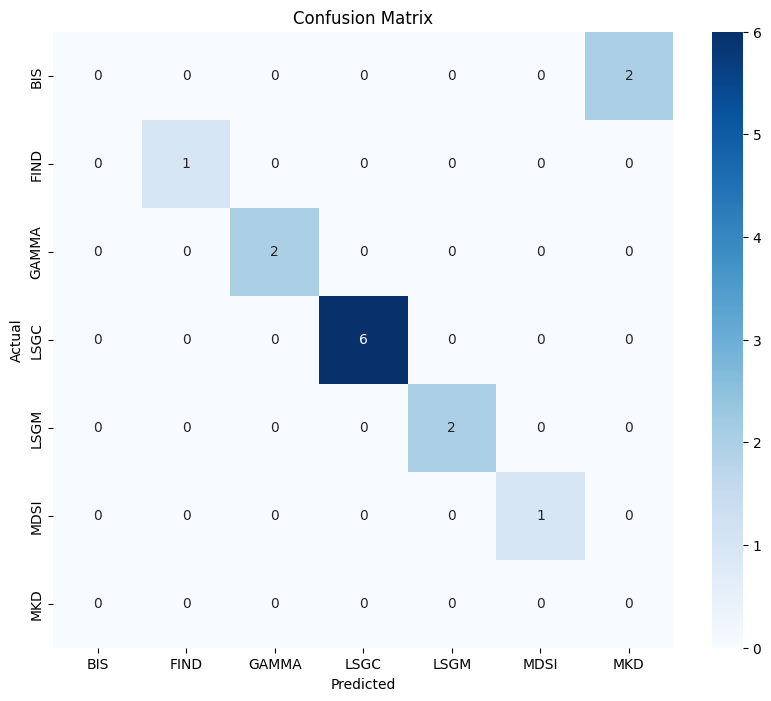

              precision    recall  f1-score   support

         BIS       0.00      0.00      0.00         2
        FIND       1.00      1.00      1.00         1
       GAMMA       1.00      1.00      1.00         2
        LSGC       1.00      1.00      1.00         6
        LSGM       1.00      1.00      1.00         2
        MDSI       1.00      1.00      1.00         1
         MKD       0.00      0.00      0.00         0

    accuracy                           0.86        14
   macro avg       0.71      0.71      0.71        14
weighted avg       0.86      0.86      0.86        14



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
# Vectorize the features
competences_vectorizer = TfidfVectorizer(max_features=1000)
metier_vectorizer = TfidfVectorizer(max_features=100)

encoded_skills = competences_vectorizer.fit_transform(match_df['Compétences_esb'])
encoded_metier = metier_vectorizer.fit_transform(match_df['Métier'])

# Compute cosine similarity and combine features
X_competences_similarity = cosine_similarity(encoded_skills)
X_competences_flat = np.mean(X_competences_similarity, axis=1).reshape(-1, 1)
X = hstack([X_competences_flat, encoded_metier])

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(match_df['Parcours'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Grid Search for Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
    ),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_test)
# Get unique classes in y_pred and y_test
unique_classes = np.unique(np.concatenate((y_pred, y_test)))

# Filter target names based on unique classes
target_names = [label_encoder.classes_[i] for i in unique_classes]

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)  # Add labels here
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)  # Use filtered target_names
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report with labels parameter
print(classification_report(y_test, y_pred, target_names=target_names, labels=unique_classes))  # Add labels here

In [ ]:
# Define the recommendation function
programs = {
    'LSGC': 'Comptabilité',
    'LSGM': 'Management',
    'LMAD': 'Mathématiques Appliquées à l’Analyse des Données et à l’Aide à la Décision',
    'BI': 'Business Intelligence',
    'BIS': 'Business Information Systems',
    'MKD': 'marketing digital',
    'CCA': 'Comptabilité, Contrôle, Audit',
    'MDSI': 'Management Digital et Systèmes d’Information',
    'GAMMA': 'Gestion Actuarielle et Modélisation Mathématique',
    'FIND': 'Finance Digitale',
    'BA': 'Business Analytics'
}

def recommend_parcours(input_metier, input_competences):
    # Preprocess inputs
    input_metier = preprocess_text(input_metier)
    input_competences = preprocess_text(input_competences)

    # Vectorize inputs
    metier_vec = metier_vectorizer.transform([input_metier])
    competences_vec = competences_vectorizer.transform([input_competences])

    # Combine vectors
    competences_vec = csr_matrix(competences_vec, shape=(competences_vec.shape[0], X_train.shape[1] - metier_vec.shape[1]))
    input_features = hstack([competences_vec, metier_vec]).tocsr()

    # Predict top recommendations
    proba = best_model.predict_proba(input_features)
    top_indices = proba.argsort()[0, -5:][::-1]
    top_parcours = label_encoder.inverse_transform(top_indices)

    return [programs[parcours.upper()] for parcours in top_parcours if parcours.upper() in programs]

# Example usage
input_metier = "comptable"
input_competences = "comptabilité, trésorerie"
recommendations = recommend_parcours(input_metier, input_competences)
print("Recommended Parcours:", recommendations)

Recommended Parcours: ['Business Analytics', 'Business Intelligence', 'marketing digital', 'Mathématiques Appliquées à l’Analyse des Données et à l’Aide à la Décision', 'Management']


In [ ]:
# Example usage accuracy 0.5
# Preprocess the input
input_metier = "Data Scientist"
input_competences ="Statistique, Machine Learning, Data"

# Get recommendations
recommendations = recommend_parcours(input_metier, input_competences)
print("Recommended Parcours:", recommendations)

Recommended Parcours: ['Business Analytics', 'Business Intelligence', 'marketing digital', 'Mathématiques Appliquées à l’Analyse des Données et à l’Aide à la Décision', 'Management']


In [ ]:
#Accuracy 0.57 results are not relevant
'''from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
import numpy as np

# Ensure both 'Compétences' and 'Métier' are properly vectorized
competences_vectorizer = TfidfVectorizer(max_features=1000)
metier_vectorizer = TfidfVectorizer(max_features=100)

# Vectorize features
encoded_skills = competences_vectorizer.fit_transform(match_df['Compétences_esb'])
encoded_metier = metier_vectorizer.fit_transform(match_df['Métier'])

# Compute cosine similarity across all rows in `encoded_skills`
X_competences_similarity = cosine_similarity(encoded_skills)

# Flatten cosine similarity matrix into a feature vector (optional step)
# Alternatively, you could use a subset or summary statistics if needed
X_competences_flat = np.mean(X_competences_similarity, axis=1).reshape(-1, 1)

# Combine cosine similarity with 'Métier' features
X = hstack([X_competences_flat, encoded_metier])

# Encode the target variable (Parcours)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(match_df['Parcours'])

# Ensure dimensions of X and y match
if X.shape[0] != len(y):
    raise ValueError(f"Mismatch in dimensions: X has {X.shape[0]} rows, but y has {len(y)}.")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

# Get unique labels in y_test and y_pred
unique_labels = np.unique(np.concatenate((y_test, y_pred)))

# Filter label_encoder.classes_ to include only the present labels
target_names = [label_encoder.classes_[i] for i in unique_labels]

# Print classification report with filtered target_names
print(classification_report(y_test, y_pred, target_names=target_names)) '''

              precision    recall  f1-score   support

          BI       0.00      0.00      0.00         0
         BIS       1.00      1.00      1.00         2
        FIND       0.00      0.00      0.00         1
       GAMMA       0.00      0.00      0.00         2
        LSGC       1.00      0.67      0.80         6
        LSGM       0.50      0.50      0.50         2
        MDSI       1.00      1.00      1.00         1

    accuracy                           0.57        14
   macro avg       0.50      0.45      0.47        14
weighted avg       0.71      0.57      0.63        14



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



## XGBoost because Random Forest is not satisfactory
Random Forest Struggles with sparse matrices

In [ ]:
! pip install --upgrade xgboost

In [ ]:
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 16.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
import sklearn
print(sklearn.__version__)


1.5.2


In [ ]:
match_df

,Métier,Compétences_esb,Parcours
0,relationclientsbanquefinance,maîtriserlestechniquesdélaborationdessupportsd...,LSGC
1,gestiondeclientèlebancaire,maîtriserlestechniquesdélaborationdessupportsd...,LSGC
2,managementenexploitationbancaire,maîtriserlestechniquesdélaborationdessupportsd...,LSGC
3,gestionbacketmiddleofficemarchésfinanciers,maîtriserlestechniquesdélaborationdessupportsd...,LSGC
4,géranceimmobilière,maîtriserlestechniquesdélaborationdessupportsd...,LSGC
...,...,...,...
65,trésorerieetfinancement,analyseretgérerlesrisquesfinanciersparlamiseen...,FIND
66,directiondessystèmesdinformation,analyseretgérerlesrisquesfinanciersparlamiseen...,FIND
67,conseiletmaîtrisedouvrageensystèmesdinformation,analyseretgérerlesrisquesfinanciersparlamiseen...,FIND
68,conceptionetexpertiseproduitsbancairesetfinanc...,conceptualisermodéliseretanalyserdesdonnéesmas...,BA


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import numpy as np

# Vectorize features
competences_vectorizer = TfidfVectorizer(max_features=1000)
metier_vectorizer = TfidfVectorizer(max_features=100)

encoded_skills = competences_vectorizer.fit_transform(match_df['Compétences_esb'])
encoded_metier = metier_vectorizer.fit_transform(match_df['Métier'])

# Combine features
X = hstack([encoded_skills, encoded_metier])

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(match_df['Parcours'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to train XGBoost model
def train_xgboost_model(X_train, y_train, params=None):
    """Train XGBoost model with given parameters."""
    if params is None:
        params = {
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'objective': 'multi:softprob',  # For probabilistic outputs
            'num_class': len(np.unique(y_train)),  # Dynamically set number of classes
            'eval_metric': 'mlogloss',
            'use_label_encoder': False
        }

    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True
    )
    return model

# Train the model
xg_model = train_xgboost_model(X_train, y_train)

[0]	validation_0-mlogloss:2.17909	validation_1-mlogloss:2.18068
[1]	validation_0-mlogloss:1.97938	validation_1-mlogloss:1.97906
[2]	validation_0-mlogloss:1.81977	validation_1-mlogloss:1.81664
[3]	validation_0-mlogloss:1.68623	validation_1-mlogloss:1.68136
[4]	validation_0-mlogloss:1.57259	validation_1-mlogloss:1.56684
[5]	validation_0-mlogloss:1.47636	validation_1-mlogloss:1.46774
[6]	validation_0-mlogloss:1.39239	validation_1-mlogloss:1.38178
[7]	validation_0-mlogloss:1.31846	validation_1-mlogloss:1.30658
[8]	validation_0-mlogloss:1.25378	validation_1-mlogloss:1.24206
[9]	validation_0-mlogloss:1.19603	validation_1-mlogloss:1.18475
[10]	validation_0-mlogloss:1.14466	validation_1-mlogloss:1.13298
[11]	validation_0-mlogloss:1.09835	validation_1-mlogloss:1.08656
[12]	validation_0-mlogloss:1.05644	validation_1-mlogloss:1.04477
[13]	validation_0-mlogloss:1.01858	validation_1-mlogloss:1.00649
[14]	validation_0-mlogloss:0.98409	validation_1-mlogloss:0.97184
[15]	validation_0-mlogloss:0.95261	

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:42:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[37]	validation_0-mlogloss:0.63325	validation_1-mlogloss:0.63868
[38]	validation_0-mlogloss:0.62701	validation_1-mlogloss:0.63345
[39]	validation_0-mlogloss:0.62112	validation_1-mlogloss:0.62855
[40]	validation_0-mlogloss:0.61554	validation_1-mlogloss:0.62395
[41]	validation_0-mlogloss:0.61026	validation_1-mlogloss:0.61963
[42]	validation_0-mlogloss:0.60525	validation_1-mlogloss:0.61556
[43]	validation_0-mlogloss:0.60050	validation_1-mlogloss:0.61173
[44]	validation_0-mlogloss:0.59599	validation_1-mlogloss:0.60812
[45]	validation_0-mlogloss:0.59171	validation_1-mlogloss:0.60471
[46]	validation_0-mlogloss:0.58764	validation_1-mlogloss:0.60149
[47]	validation_0-mlogloss:0.58377	validation_1-mlogloss:0.59845
[48]	validation_0-mlogloss:0.58008	validation_1-mlogloss:0.59557
[49]	validation_0-mlogloss:0.57657	validation_1-mlogloss:0.59285
[50]	validation_0-mlogloss:0.57322	validation_1-mlogloss:0.59026
[51]	validation_0-mlogloss:0.57003	validation_1-mlogloss:0.58781
[52]	validation_0-mloglos

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score # Import cross_val_score from the correct module

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance."""
    # ... (rest of your code remains the same)def evaluate_model(model, X_test, y_test):
    """Evaluate model performance."""
    predictions = model.predict(X_test)

    results = {
        'accuracy': accuracy_score(y_test, predictions),
        'classification_report': classification_report(y_test, predictions),
        'confusion_matrix': confusion_matrix(y_test, predictions),
        'cv_scores': cross_val_score(model, X_test, y_test, cv=5)
    }

    return results

# Map labels in y_test to a consecutive range
unique_labels = np.unique(y_test)
label_mapping = {label: i for i, label in enumerate(unique_labels)}
y_test_mapped = np.array([label_mapping[label] for label in y_test])

# Evaluate with the mapped labels
results = evaluate_model(xg_model, X_test, y_test_mapped)
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"CV Mean: {results['cv_scores'].mean():.4f} (+/- {results['cv_scores'].std()*2:.4f})")
print("\nClassification Report:")
print(results['classification_report'])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

Accuracy: 0.0000
CV Mean: nan (+/- nan)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       2.0
           1       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       2.0
           3       0.00      0.00      0.00       6.0
           4       0.00      0.00      0.00       2.0
           5       0.00      0.00      0.00       1.0
           7       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       0.0

    accuracy                           0.00      14.0
   macro avg       0.00      0.00      0.00      14.0
weighted avg       0.00      0.00      0.00      14.0



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4], got [0 2 

In [ ]:
# Recommendation function
programs = {
    'LSGC': 'Comptabilité',
    'LSGM': 'Management',
    'LMAD': 'Mathématiques Appliquées à l’Analyse des Données et à l’Aide à la Décision',
    'BI': 'Business Intelligence',
    'BIS': 'Business Information Systems',
    'MKD': 'marketing digital',
    'CCA': 'Comptabilité, Contrôle, Audit',
    'MDSI': 'Management Digital et Systèmes d’Information',
    'GAMMA': 'Gestion Actuarielle et Modélisation Mathématique',
    'FIND': 'Finance Digitale',
    'BA': 'Business Analytics'
}

def recommend_parcours_xgb(input_metier, input_competences):
    # Preprocess inputs
    input_metier = preprocess_text(input_metier)
    input_competences = preprocess_text(input_competences)

    # Vectorize inputs
    metier_vec = metier_vectorizer.transform([input_metier])
    competences_vec = competences_vectorizer.transform([input_competences])

    # Combine features
    input_features = hstack([competences_vec, metier_vec])

    # Predict top recommendations
    proba = xg_model.predict_proba(input_features)
    top_indices = proba.argsort()[0, -5:][::-1]
    top_parcours = label_encoder.inverse_transform(top_indices)

    return [programs.get(parcours.upper(), parcours) for parcours in top_parcours]



In [ ]:
# Example usage
input_metier = "ingenieur informatique"
input_competences = "Statistique, Machine Learning, Data"
recommendations = recommend_parcours_xgb(input_metier, input_competences)
print("Recommended Parcours:", recommendations)

Recommended Parcours: ['Business Analytics', 'Business Intelligence', 'Mathématiques Appliquées à l’Analyse des Données et à l’Aide à la Décision', 'Management Digital et Systèmes d’Information', 'marketing digital']


In [ ]:
# Example usage
input_metier = "data scientist"
input_competences = "Statistique, Machine Learning, Data"
recommendations = recommend_parcours_xgb(input_metier, input_competences)
print("Recommended Parcours:", recommendations)

Recommended Parcours: ['Business Analytics', 'Business Intelligence', 'Mathématiques Appliquées à l’Analyse des Données et à l’Aide à la Décision', 'Management Digital et Systèmes d’Information', 'marketing digital']


In [ ]:
# Example usage
input_metier = "financier"
input_competences = "Statistique, Machine Learning, economie"
recommendations = recommend_parcours_xgb(input_metier, input_competences)
print("Recommended Parcours:", recommendations)

Recommended Parcours: ['Business Analytics', 'Business Intelligence', 'Mathématiques Appliquées à l’Analyse des Données et à l’Aide à la Décision', 'Management Digital et Systèmes d’Information', 'marketing digital']
